## training with noise-free data (sim3)

goal: train two separate neural network branches on two different features (light curve data, derivative of light curve). then, merge the two models and train again with a 3rd neural network. 

In [1]:
import numpy as np
import numpy.typing as npt
from matplotlib import pyplot as plt
from scipy.special import erf
from typing import Union 

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

# note: removed the EFP and plot_flare functions here, but can add back

2024-06-01 08:12:14.885235: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## getting the synthetic data
for now, I am just training on all flares without sifting, but i can also filter by the snr to get even better data. 

In [2]:
import pandas as pd
class_info = pd.read_csv('sim3/simulated_flares.csv')

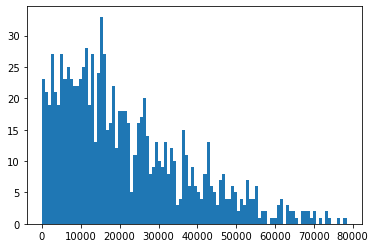

In [3]:
# see the SNR distribution
plt.hist(class_info['snr'], bins = 100);

In [4]:
# snr_filter
print(np.shape(np.where(class_info['snr'] > 10000)))
print(np.shape(np.where(class_info['peak_count'] > 50) ))

(1, 710)
(1, 997)


In [5]:
# get the light curve data 
# if we want to only use the higher snr data, then just use the indices
# high_snr_id = list(np.where(class_info['snr'] > 10000)[0])

ids = [i for i in class_info['identifier']]
peak_count = [int(count) for count in class_info['peak_count']]

data = []
labels = []

for i in ids:
    tod = pd.read_csv('sim3/flares/' + f'{i}' + '.csv')
    data.append(list(tod['Counts']))
    
for index in range(len(class_info)):
    if str(class_info['flare_type'][index]) == 'A':
        labels.append(0)
    if str(class_info['flare_type'][index]) == 'B':
        labels.append(1)
    else:
        continue

In [6]:
data = pad_sequences(data, padding='post', dtype=float)   # the padding is to adjust the shape of the np arrays

print(data[0])
print(data.shape)
print(type(data[0, 0]))

[218.89267671 218.88938892 218.88611579 ...   0.           0.
   0.        ]
(1000, 1999)
<class 'numpy.float64'>


In [7]:
# getting the derivative of the light curve

data_deriv = [ (data[i][1:] - data[i][:-1]) for i in range(len(data)) ] 

data_deriv = pad_sequences(data_deriv, padding='post', dtype=float)   # the padding is to adjust the shape of the np arrays

print(data_deriv[0])
print(data_deriv.shape)
print(type(data_deriv[0, 0]))

[-0.00328779 -0.00327313 -0.00325786 ...  0.          0.
  0.        ]
(1000, 1998)
<class 'numpy.float64'>


## construct two neural network branches
- model1: training on the light curve data  
- model2: training on the derivative of the light curve data

In [8]:
model1 = Sequential()
    
# First convolutional layer
model1.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(len(data[0]), 1)))
model1.add(MaxPooling1D(pool_size=2))

# Second convolutional layer
model1.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model1.add(MaxPooling1D(pool_size=2))

# Third convolutional layer
model1.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model1.add(MaxPooling1D(pool_size=2))

# Flatten the output
model1.add(Flatten())

# Fully connected layer
model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.5))

# Output layer
model1.add(Dense(1, activation='sigmoid'))

# Compile the model
model1.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

2024-06-01 08:12:21.702196: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9622 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:06:00.0, compute capability: 7.5


In [9]:
model2 = Sequential()

# First convolutional layer
model2.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(len(data_deriv[0]), 1)))
model2.add(MaxPooling1D(pool_size=2))

# Second convolutional layer
model2.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model2.add(MaxPooling1D(pool_size=2))

# Third convolutional layer
model2.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model2.add(MaxPooling1D(pool_size=2))

# Flatten the output
model2.add(Flatten())

# Fully connected layer
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))

# Output layer
model2.add(Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

## training model1 and model2

In [10]:
model1.fit(np.array(data), np.array(labels), epochs=100, batch_size=32, validation_split=0.2, verbose=0)

2024-06-01 08:12:24.371311: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-06-01 08:12:25.259777: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f61bcd485e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-01 08:12:25.259833: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-06-01 08:12:25.267440: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-01 08:12:25.480621: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [11]:
model2.fit(np.array(data_deriv), np.array(labels), epochs=100, batch_size=32, validation_split=0.2, verbose=0)

In [12]:
print(np.expand_dims(data, axis=-1).shape)
print(np.expand_dims(data_deriv, axis=-1).shape)

preds1 = model1.predict(np.expand_dims(data, axis=-1))
preds2 = model2.predict(np.expand_dims(data_deriv, axis=-1))

(1000, 1999, 1)
(1000, 1998, 1)
32/32 [==============================] - 0s 3ms/step


## evaluating the initial training 

In [13]:
# training for model 1 

from tqdm import tqdm 

class_list = {'0': 'A' , '1': 'B'}

num_high_1 = 0
num_mis_high_1 = 0
num_mis_low_1 = 0

mis_index_1 = [] # identifier list of misclassified flares

tot_exc = 0

for i, pred in enumerate(tqdm(preds1)):
    conf = np.abs(preds1[0]-0.5)+0.5     # pred is just 1 number 
    pred_class = int(np.round(preds1[0]))
    
    tot_exc += 1
    
    if conf > 0.9:
        num_high_1 += 1

        if class_list[str(pred_class)] != class_list[str(labels[i])]:
            num_mis_high_1 += 1
            mis_index_1.append(i)
            
            
    else:

        if class_list[str(pred_class)] != class_list[str(labels[i])]:
            num_mis_low_1 += 1
            mis_index_1.append(i)

100%|██████████| 1000/1000 [00:00<00:00, 47536.68it/s]


In [14]:
len(mis_index_1)

460

In [15]:
# training for model 2 
class_list = {'0': 'A' , '1': 'B'}

num_high_2 = 0
num_mis_high_2 = 0
num_mis_low_2 = 0

mis_index_2 = [] # identifier list of misclassified flares

tot_exc = 0

for i, pred in enumerate(tqdm(preds2)):
    conf = np.abs(preds2[0]-0.5)+0.5     # pred is just 1 number 
    pred_class = int(np.round(preds2[0]))
    
    tot_exc += 1
    
    if conf > 0.9:
        num_high_2 += 1

        if class_list[str(pred_class)] != class_list[str(labels[i])]:
            num_mis_high_2 += 1
            mis_index_2.append(i)
    else:

        if class_list[str(pred_class)] != class_list[str(labels[i])]:
            num_mis_low_2 += 1
#             mis_index_2.append(i)

100%|██████████| 1000/1000 [00:00<00:00, 60222.32it/s]


In [16]:
# seems to be misidentifiying the same flares
mis_index_1 == mis_index_2

True

In [18]:
print('for model1:')
print(f'Number of high confidence classifications = {num_high_1}')
print(f'Number of low confidence classifications = {len(preds1) - num_high_1}')
print(f'Percentage of high confidence = {num_high_1/len(preds1)}')

print(f'Total misclassified = {num_mis_high_1 + num_mis_low_1}')
print(f'Accuracy in total = {1-(num_mis_high_1+ num_mis_low_1)/len(preds1)}')

print(f'Accuracy of high confidence = {1-num_mis_high_1/num_high_1}')
# print(f'Accuracy of low confidence = {1-num_mis_low_1/(len(preds1) - num_high_1)}')

for model1:
Number of high confidence classifications = 1000
Number of low confidence classifications = 0
Percentage of high confidence = 1.0
Total misclassified = 460
Accuracy in total = 0.54
Accuracy of high confidence = 0.54


In [19]:
print('for model2:')
print(f'Number of high confidence classifications = {num_high_2}')
print(f'Number of low confidence classifications = {len(preds2) - num_high_2}')
print(f'Percentage of high confidence = {num_high_2/len(preds2)}')

print(f'Total misclassified = {num_mis_high_2 + num_mis_low_2}')
print(f'Accuracy in total = {1-(num_mis_high_2+ num_mis_low_2)/len(preds2)}')

print(f'Accuracy of high confidence = {1-num_mis_high_2/num_high_2}')
# print(f'Accuracy of low confidence = {1-num_mis_low_2/(len(preds2) - num_high_2)}')

for model2:
Number of high confidence classifications = 1000
Number of low confidence classifications = 0
Percentage of high confidence = 1.0
Total misclassified = 460
Accuracy in total = 0.54
Accuracy of high confidence = 0.54


  0%|          | 0/1000 [00:00<?, ?it/s]

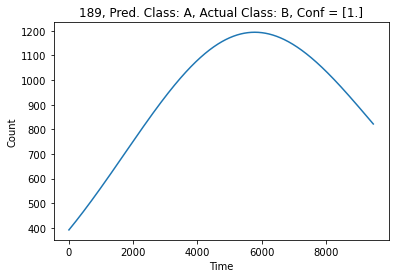

 19%|█▉        | 190/1000 [00:00<00:00, 1459.24it/s]

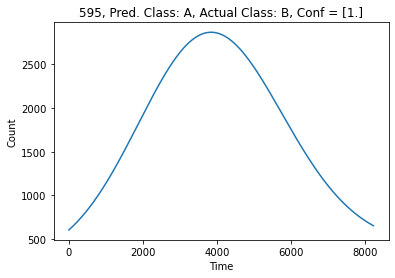

 60%|█████▉    | 596/1000 [00:00<00:00, 2595.12it/s]

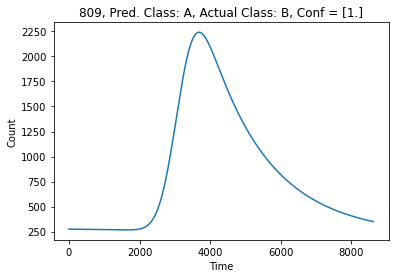

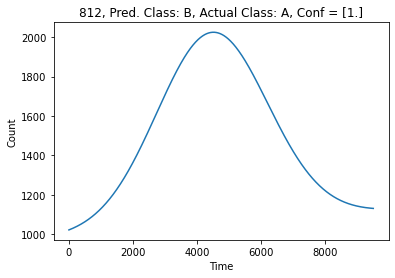

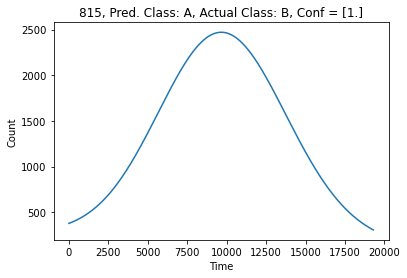

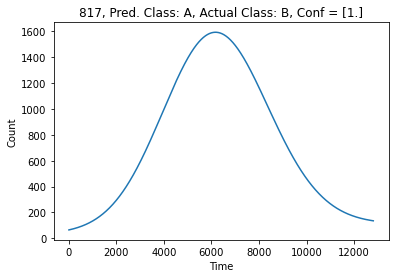

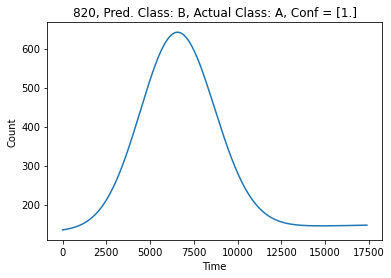

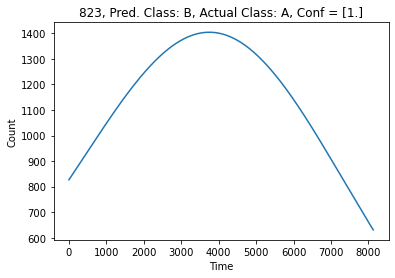

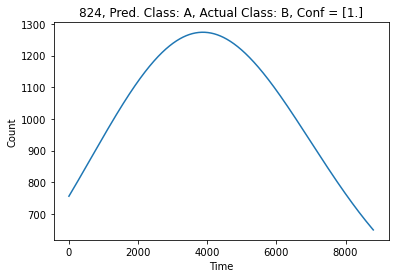

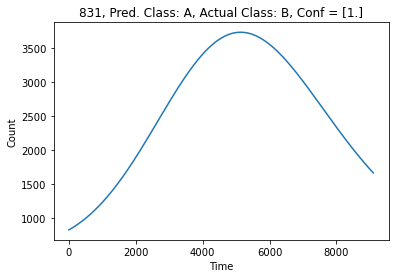

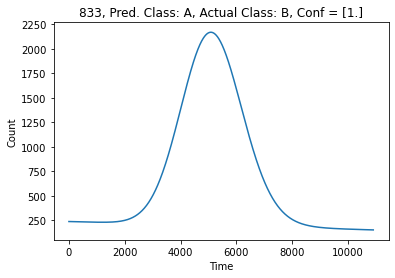

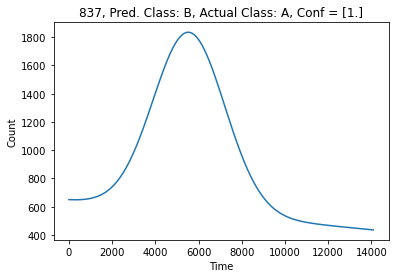

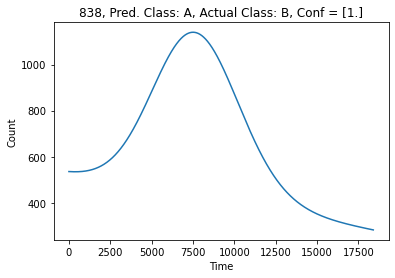

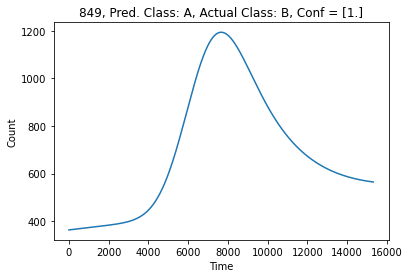

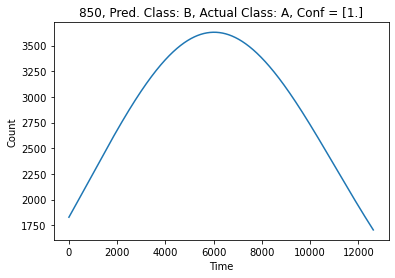

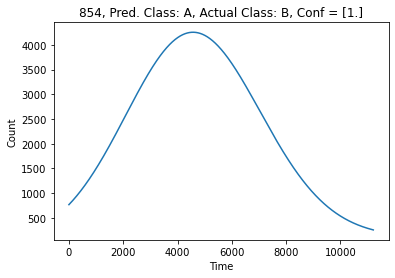

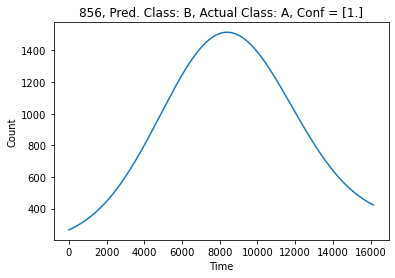

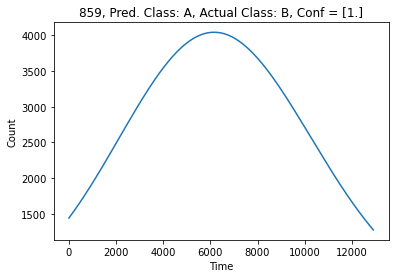

 86%|████████▌ | 861/1000 [00:02<00:00, 240.12it/s] 

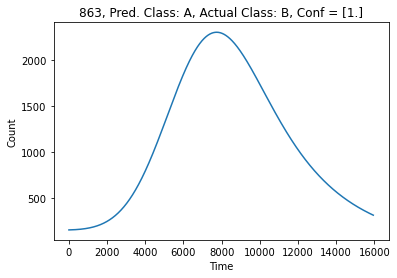

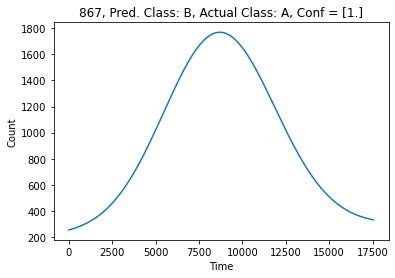

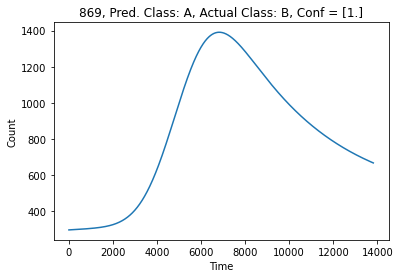

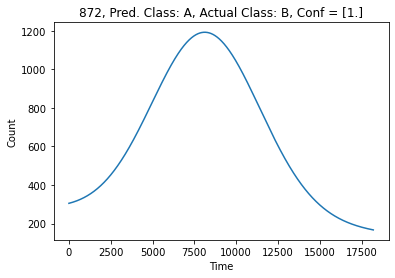

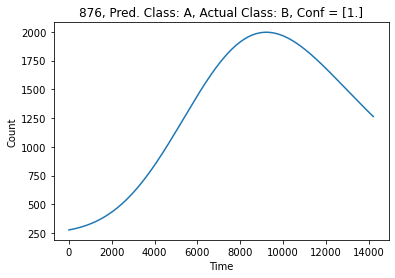

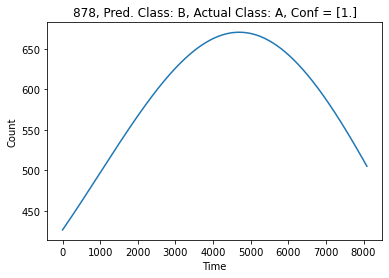

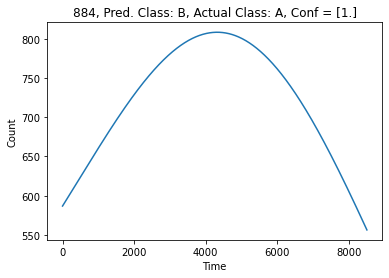

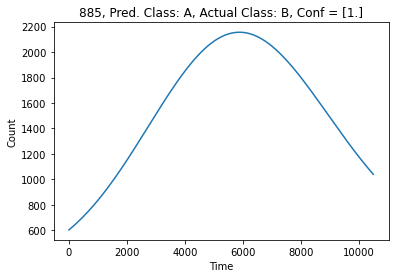

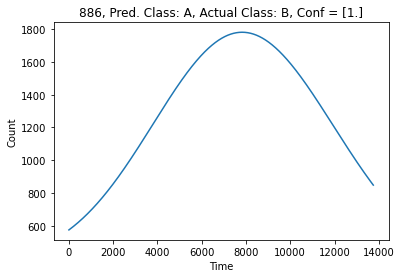

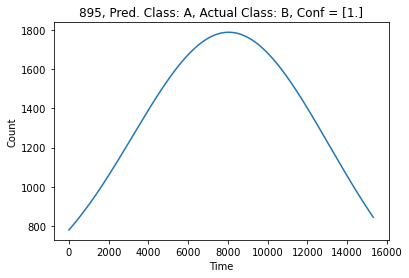

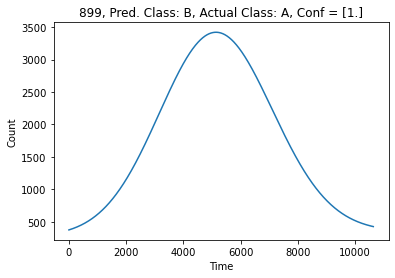

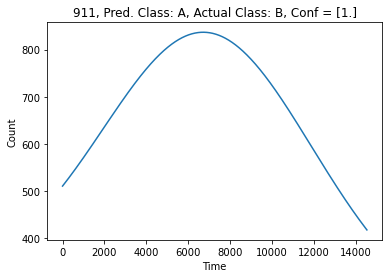

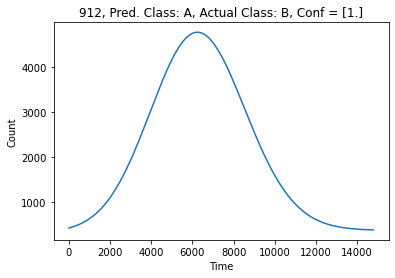

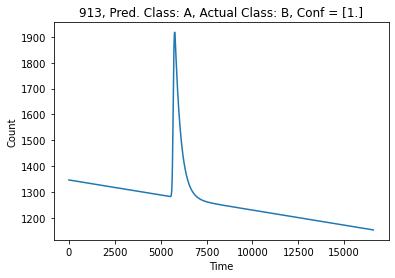

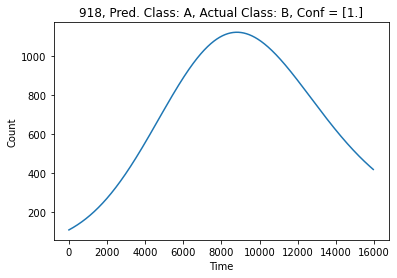

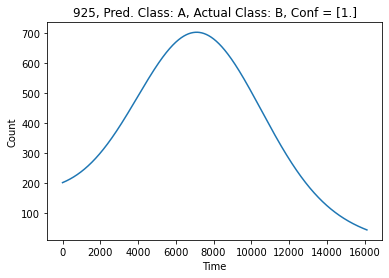

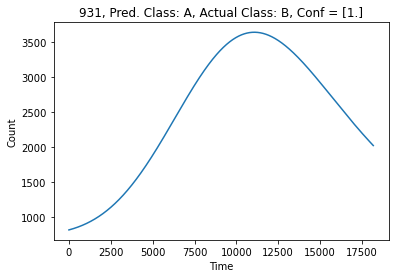

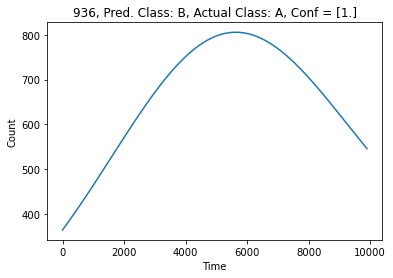

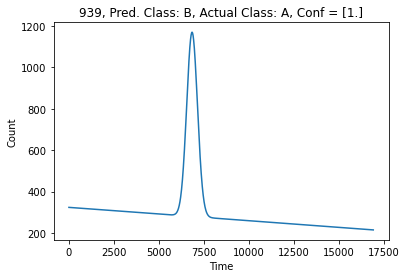

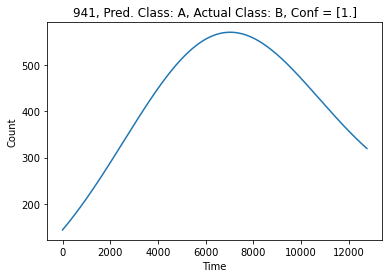

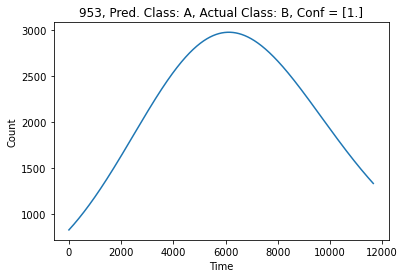

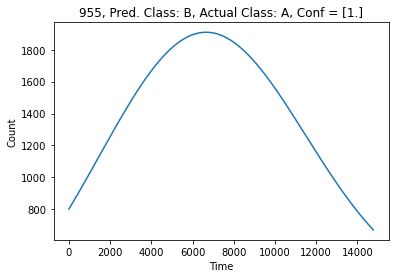

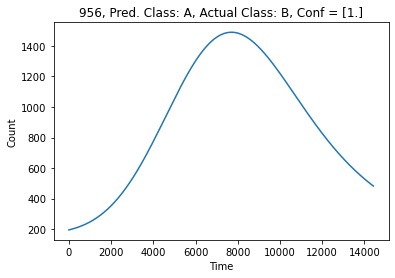

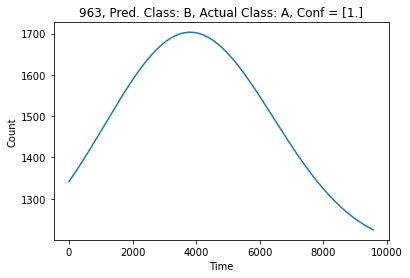

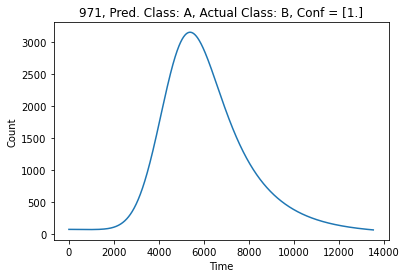

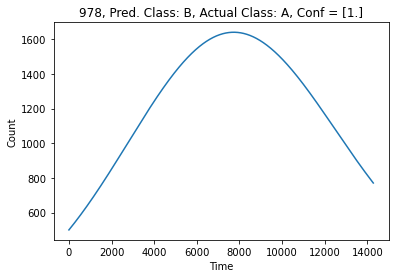

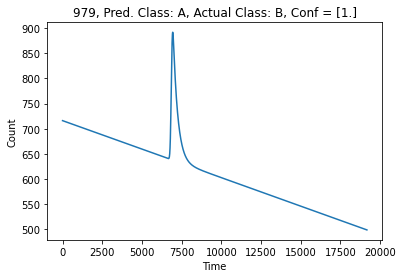

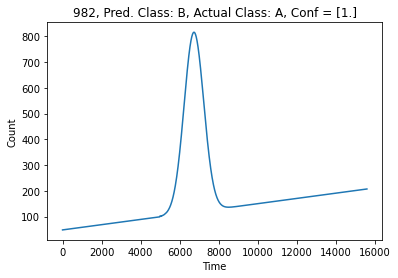

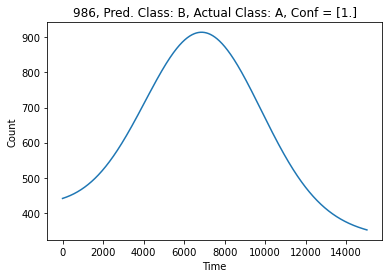

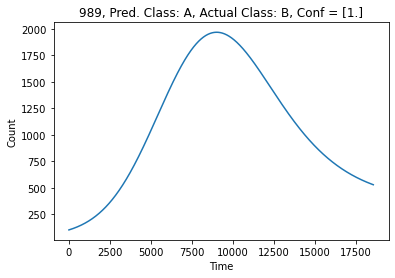

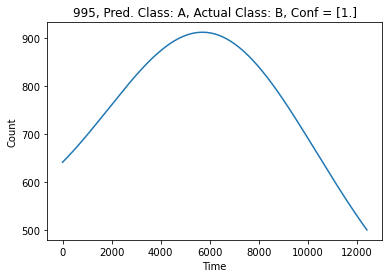

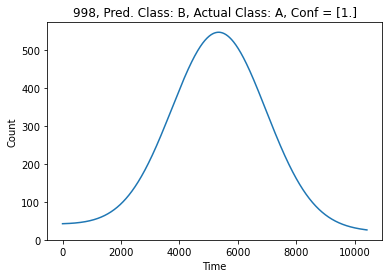

100%|██████████| 1000/1000 [00:07<00:00, 137.11it/s]


In [20]:
# plotting misclassified 
for i, pred2 in enumerate(tqdm(preds2)):
    pred2_class = int(np.round(pred2[0]))
    if class_list[str(pred2_class)] != class_list[str(labels[i])]:
        plt.plot(np.arange(0, len(data[i][data[i] != 0]))*10, data[i][data[i] != 0])

        plt.xlabel('Time')
        plt.ylabel('Count')

        plt.title(f"{ids[i]}, Pred. Class: {class_list[str(pred2_class)]}, Actual Class: {class_list[str(labels[i])]}, Conf = {np.round(conf, 3)}")
        plt.show()

# merge the layers 

In [21]:
from keras.layers import Concatenate

# Concatenate the outputs of the two models
merged = Concatenate()([model1.output, model2.output])

# Add more layers 
x = Dense(64, activation='relu')(merged)
final_output = Dense(1, activation='sigmoid')(x)

# # Create the final model

In [22]:
from keras.models import Model
combined_model = Model(inputs=[model1.input, model2.input], outputs=final_output)
combined_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
combined_model.fit([data, data_deriv], np.array(labels), epochs=100, batch_size=32)

Epoch 1/100
32/32 [==============================] - 6s 16ms/step - loss: 0.6356 - accuracy: 0.5620
Epoch 2/100
32/32 [==============================] - 0s 15ms/step - loss: 0.5491 - accuracy: 0.7670
Epoch 3/100
32/32 [==============================] - 0s 15ms/step - loss: 0.4789 - accuracy: 0.9450
Epoch 4/100
32/32 [==============================] - 0s 15ms/step - loss: 0.4047 - accuracy: 0.9360
Epoch 5/100
32/32 [==============================] - 0s 16ms/step - loss: 0.3369 - accuracy: 0.9390
Epoch 6/100
32/32 [==============================] - 0s 15ms/step - loss: 0.3105 - accuracy: 0.9280
Epoch 7/100
32/32 [==============================] - 0s 15ms/step - loss: 0.2433 - accuracy: 0.9500
Epoch 8/100
32/32 [==============================] - 0s 15ms/step - loss: 0.2187 - accuracy: 0.9500
Epoch 9/100
32/32 [==============================] - 1s 16ms/step - loss: 0.2352 - accuracy: 0.9370
Epoch 10/100
32/32 [==============================] - 0s 14ms/step - loss: 0.2416 - accuracy: 0.9340

In [23]:
data_expanded = np.expand_dims(data, axis=-1)
data_deriv_expanded = np.expand_dims(data_deriv, axis=-1)

preds3 = combined_model.predict([data_expanded, data_deriv_expanded])

32/32 [==============================] - 0s 5ms/step


In [33]:
from tqdm import tqdm 

class_list = {'0': 'A' , '1': 'B'}

num_high = 0
num_mis_high = 0
num_mis_low = 0

tot_exc = 0
mis_index_3 = []
for i, pred3 in enumerate(tqdm(preds3)):
    conf = np.abs(pred3[0]-0.5)+0.5     # pred is just 1 number 
    pred3_class = int(np.round(pred3[0]))

    tot_exc += 1
    
    if conf > 0.9:
        #plt.savefig(f'classifications/high_confidence/{ids[i]}.png')
        num_high += 1

        if class_list[str(pred3_class)] != class_list[str(labels[i])]:
            mis_index_3.append(i)
            num_mis_high += 1
            #plt.show()
    else:
        #plt.savefig(f'classifications/low_confidence/{ids[i]}.png')

        if class_list[str(pred3_class)] != class_list[str(labels[i])]:
            num_mis_low += 1
            mis_index_3.append(i)
            #plt.show()

    #plt.close()

100%|██████████| 1000/1000 [00:00<00:00, 70542.30it/s]


In [37]:
# mis_index_3

In [38]:
print(f'Number of high confidence classifications = {num_high}')
print(f'Number of low confidence classifications = {len(preds3) - num_high}')
print(f'Percentage of high confidence = {num_high/len(preds3)}')

print(f'Total misclassified = {num_mis_high + num_mis_low}')
print(f'Accuracy in total = {1-(num_mis_high + num_mis_low)/len(preds3)}')

# print(f'Accuracy of high confidence = {1-num_mis_high/num_high}')
print(f'Accuracy of low confidence = {1-num_mis_low/(len(preds3) - num_high)}')

Number of high confidence classifications = 0
Number of low confidence classifications = 1000
Percentage of high confidence = 0.0
Total misclassified = 206
Accuracy in total = 0.794
Accuracy of low confidence = 0.794


In [39]:
print(set(mis_index_1) & set(mis_index_2) & set(mis_index_3))
print(len(set(mis_index_1) & set(mis_index_2) & set(mis_index_3)))
print(len(mis_index_3))

{768, 10, 908, 144, 403, 915, 160, 164, 551, 424, 939, 301, 686, 818, 692, 565, 436, 56, 312, 317, 449, 707, 326, 585, 464, 339, 85, 982, 343, 88, 89, 224, 868, 108, 748, 110, 112, 753, 755, 116, 884, 499, 249, 122}
44
206


##  plotting to see if it looks right

  0%|          | 0/1000 [00:00<?, ?it/s]

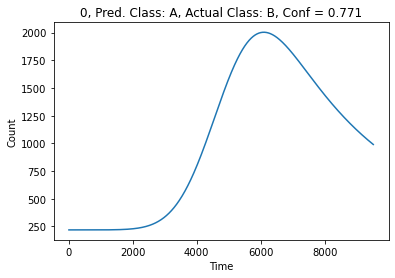

  0%|          | 1/1000 [00:00<02:17,  7.28it/s]

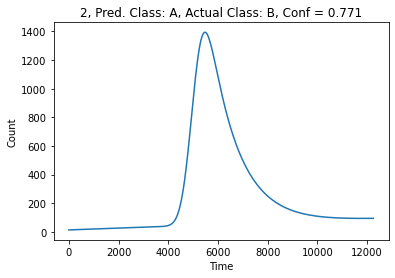

  0%|          | 3/1000 [00:00<01:29, 11.10it/s]

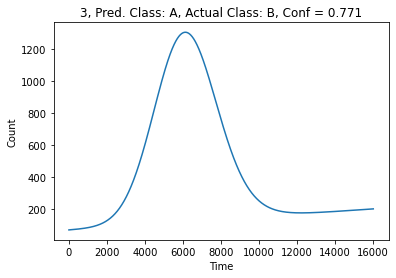

  0%|          | 5/1000 [00:00<02:23,  6.91it/s]

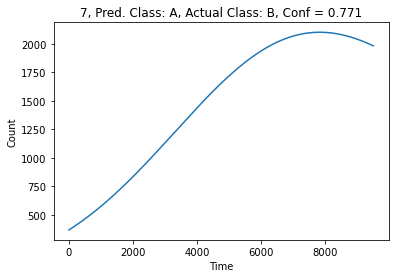

  1%|          | 8/1000 [00:00<01:32, 10.73it/s]

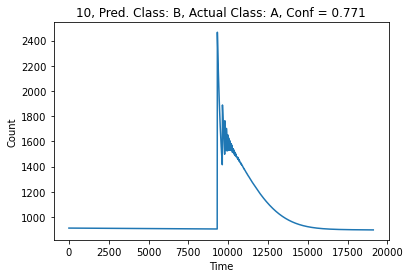

  1%|          | 11/1000 [00:00<01:11, 13.82it/s]

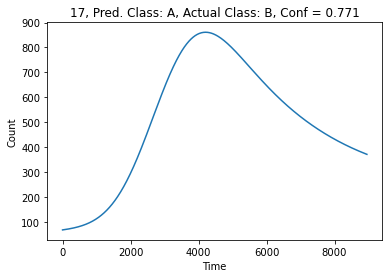

  2%|▏         | 18/1000 [00:01<00:40, 24.28it/s]

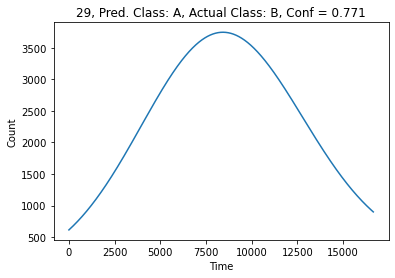

  3%|▎         | 30/1000 [00:01<00:22, 42.85it/s]

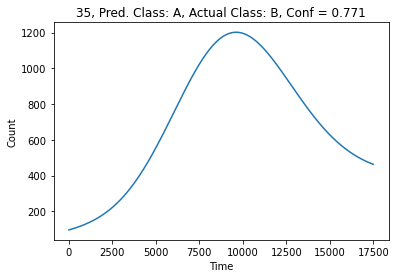

  4%|▎         | 36/1000 [00:01<00:21, 45.23it/s]

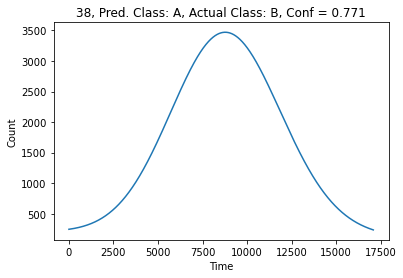

  4%|▍         | 42/1000 [00:01<00:20, 46.32it/s]

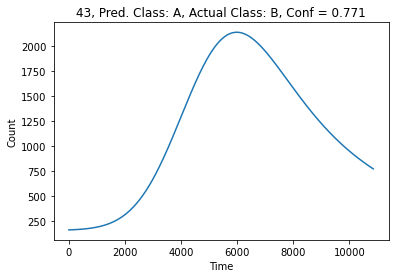

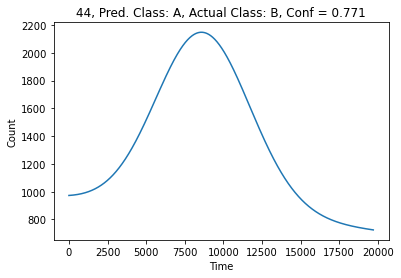

  5%|▍         | 47/1000 [00:01<00:27, 34.63it/s]

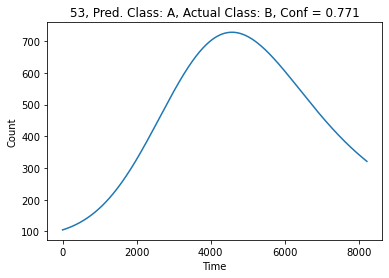

  5%|▌         | 54/1000 [00:01<00:22, 41.56it/s]

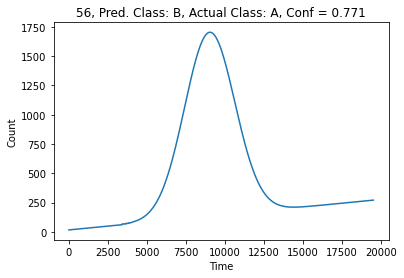

  6%|▌         | 59/1000 [00:01<00:23, 40.56it/s]

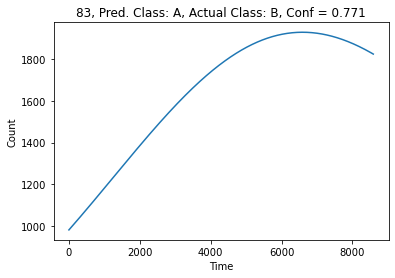

  8%|▊         | 84/1000 [00:02<00:10, 87.83it/s]

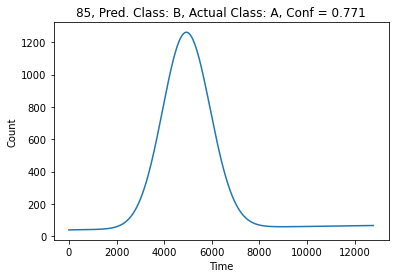

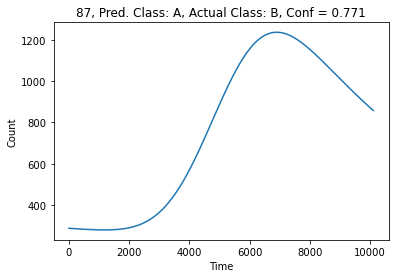

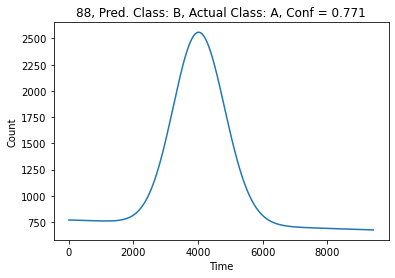

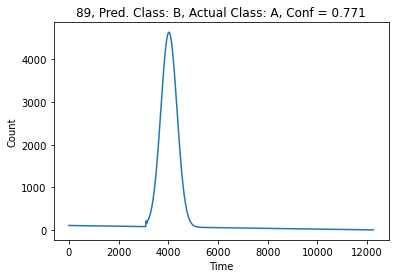

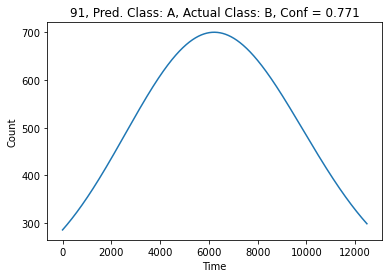

 10%|▉         | 95/1000 [00:02<00:20, 43.85it/s]

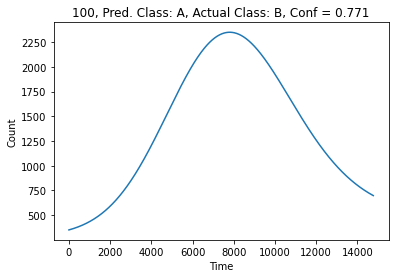

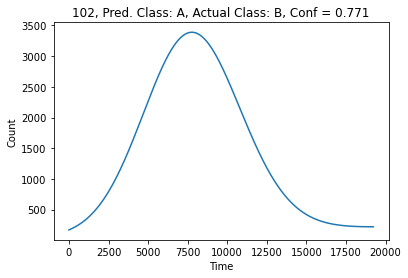

 10%|█         | 103/1000 [00:02<00:22, 40.58it/s]

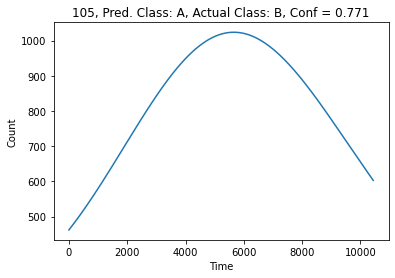

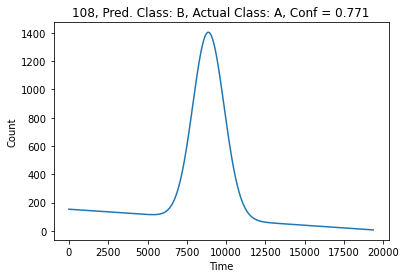

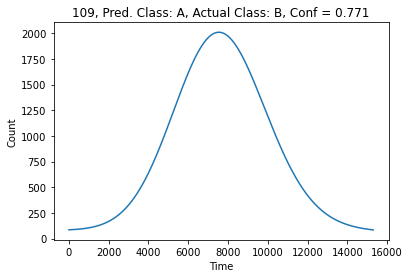

 11%|█         | 110/1000 [00:03<00:27, 32.29it/s]

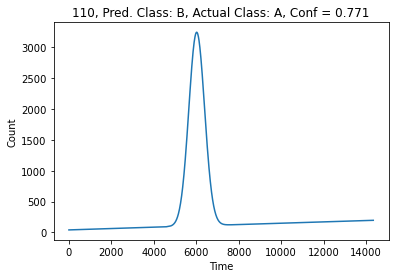

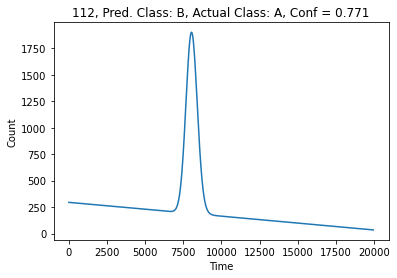

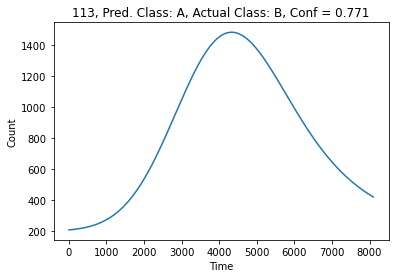

 12%|█▏        | 116/1000 [00:03<00:32, 26.79it/s]

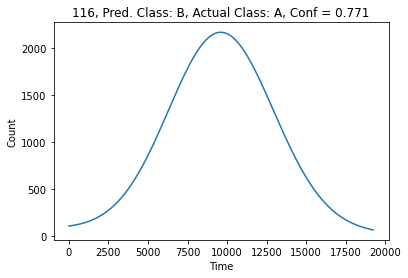

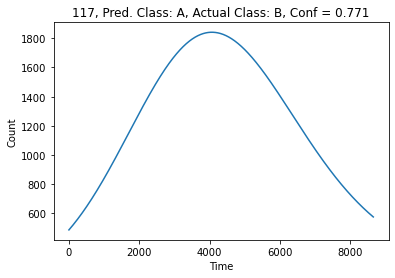

 12%|█▏        | 121/1000 [00:03<00:33, 26.11it/s]

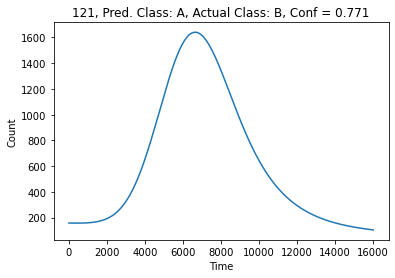

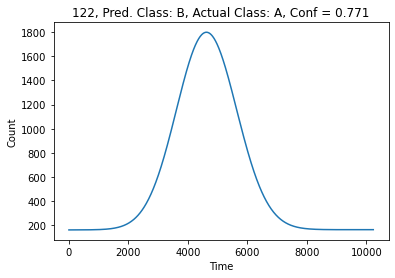

 12%|█▎        | 125/1000 [00:04<00:37, 23.55it/s]

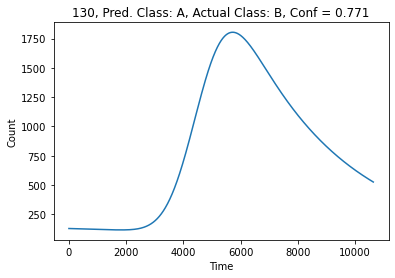

 13%|█▎        | 131/1000 [00:04<00:31, 27.96it/s]

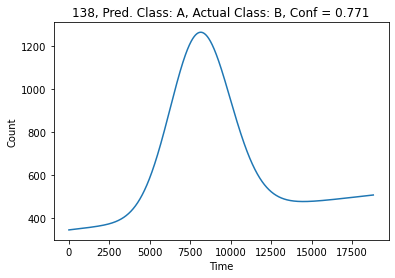

 14%|█▍        | 139/1000 [00:04<00:32, 26.50it/s]

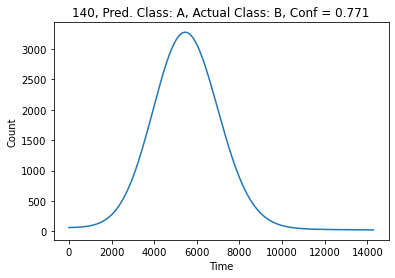

 14%|█▍        | 143/1000 [00:04<00:30, 28.03it/s]

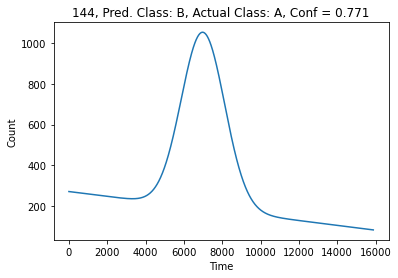

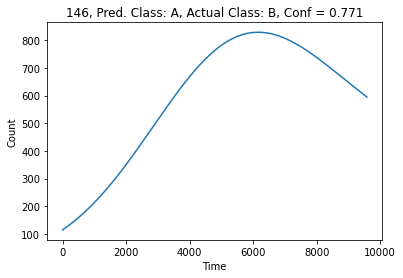

 15%|█▍        | 147/1000 [00:04<00:34, 24.88it/s]

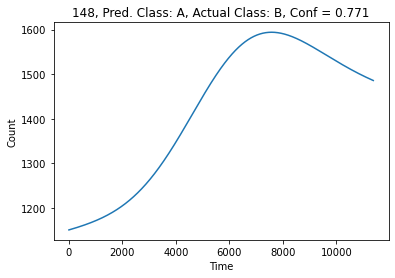

 15%|█▌        | 150/1000 [00:04<00:33, 25.45it/s]

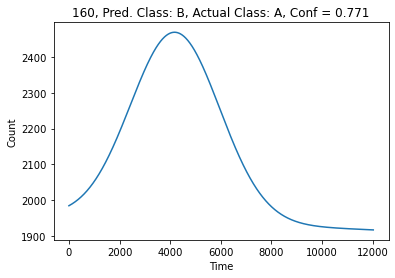

 16%|█▌        | 161/1000 [00:05<00:21, 39.23it/s]

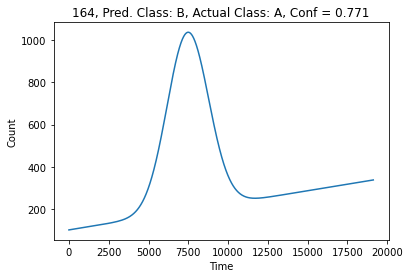

 17%|█▋        | 166/1000 [00:05<00:21, 38.94it/s]

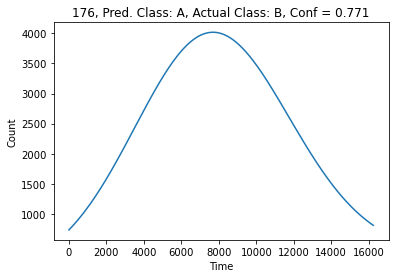

 18%|█▊        | 177/1000 [00:05<00:15, 52.21it/s]

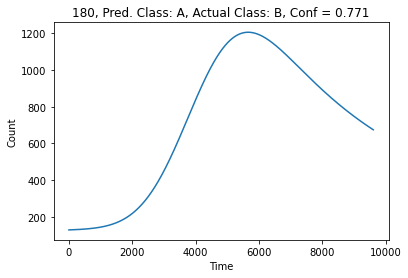

 18%|█▊        | 183/1000 [00:05<00:15, 53.74it/s]

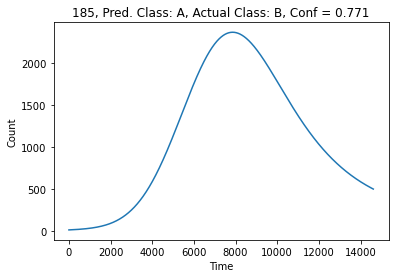

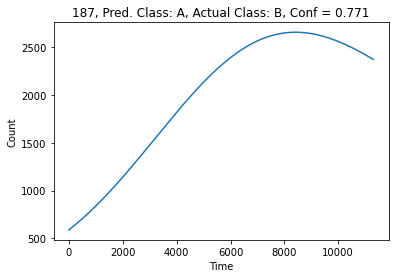

 19%|█▉        | 189/1000 [00:05<00:18, 44.17it/s]

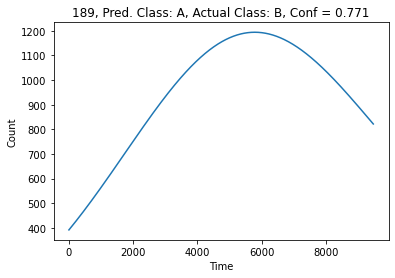

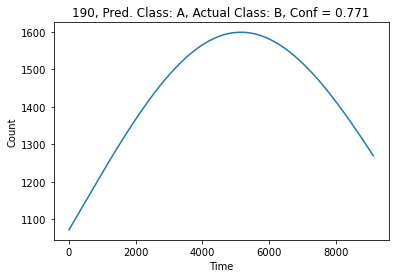

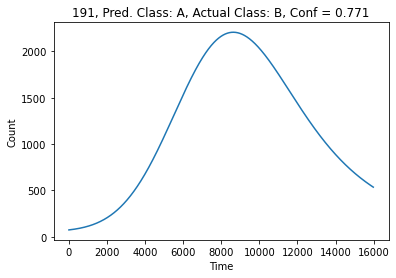

 19%|█▉        | 194/1000 [00:05<00:26, 30.54it/s]

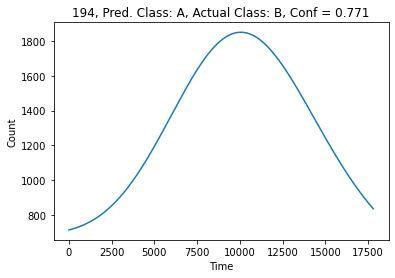

 20%|█▉        | 198/1000 [00:06<00:31, 25.51it/s]

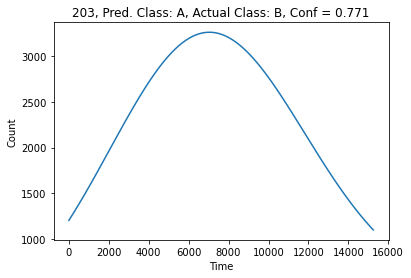

 20%|██        | 204/1000 [00:06<00:26, 30.38it/s]

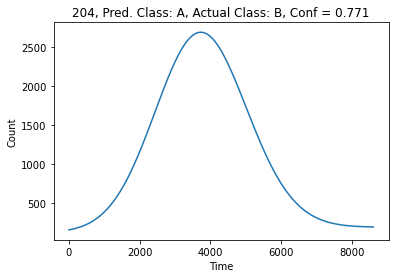

 21%|██        | 208/1000 [00:06<00:27, 29.18it/s]

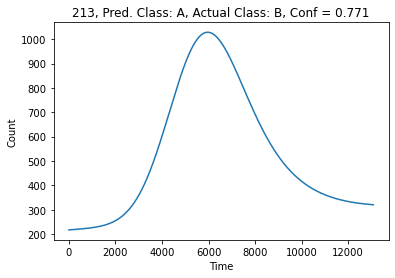

 21%|██▏       | 214/1000 [00:06<00:23, 33.60it/s]

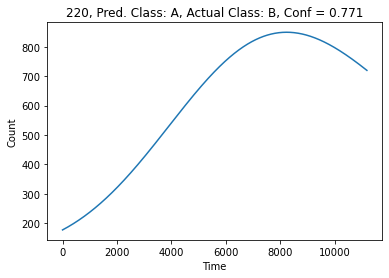

 22%|██▏       | 221/1000 [00:06<00:19, 39.75it/s]

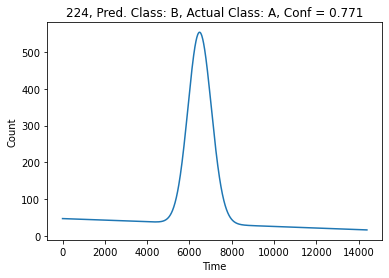

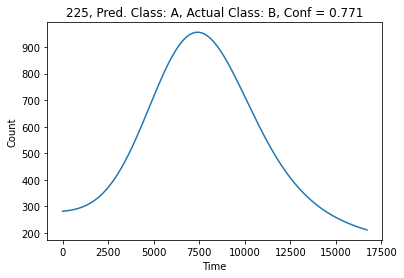

 23%|██▎       | 226/1000 [00:07<00:28, 27.62it/s]

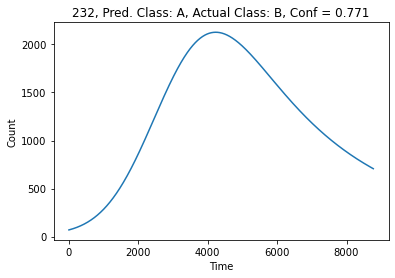

 23%|██▎       | 233/1000 [00:07<00:22, 33.88it/s]

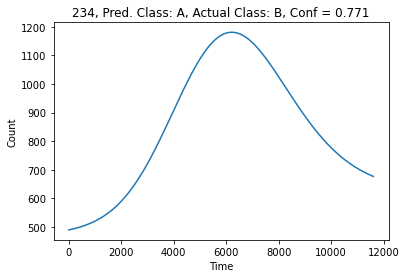

 24%|██▍       | 238/1000 [00:07<00:21, 35.72it/s]

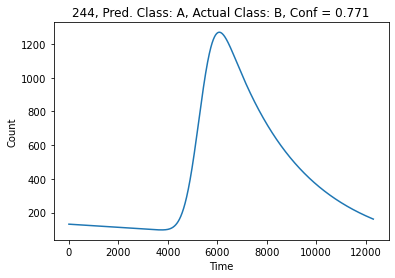

 24%|██▍       | 245/1000 [00:07<00:18, 41.12it/s]

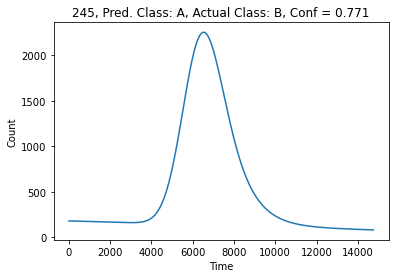

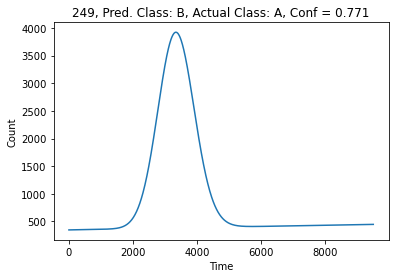

 25%|██▌       | 250/1000 [00:07<00:22, 33.36it/s]

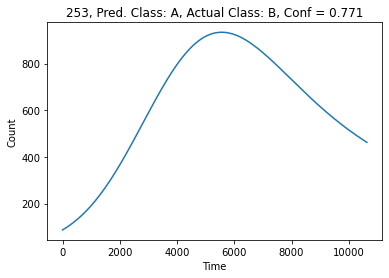

 25%|██▌       | 254/1000 [00:07<00:21, 34.54it/s]

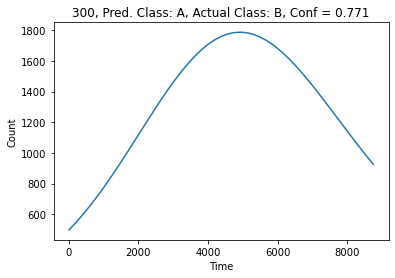

 30%|███       | 301/1000 [00:07<00:05, 127.17it/s]

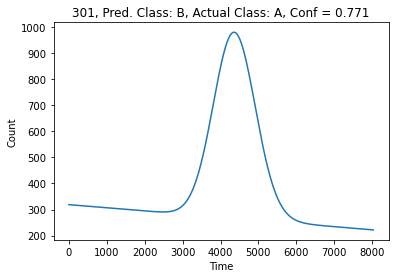

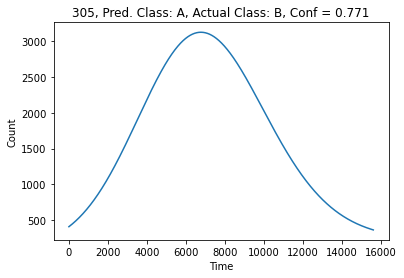

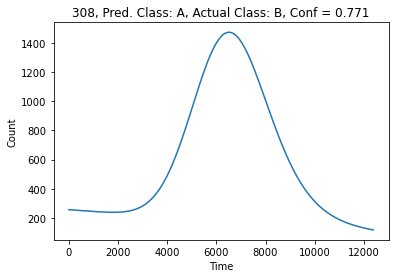

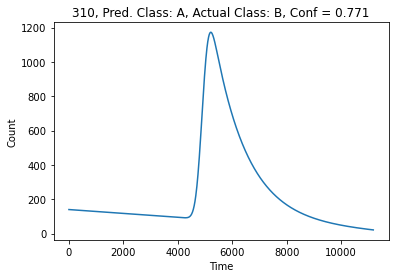

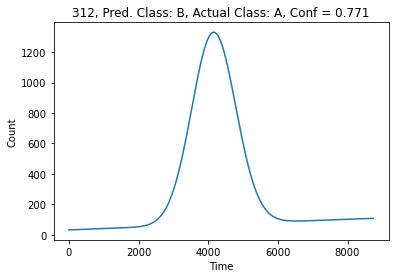

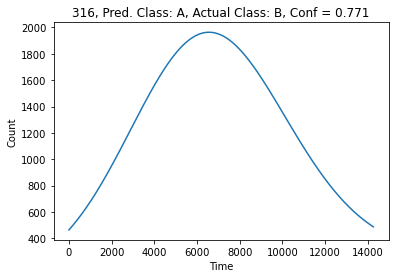

 32%|███▏      | 317/1000 [00:08<00:15, 44.42it/s] 

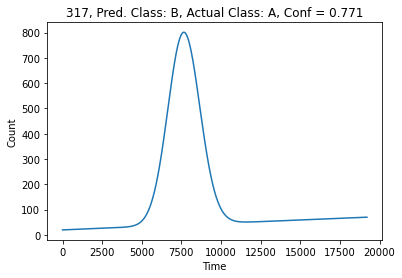

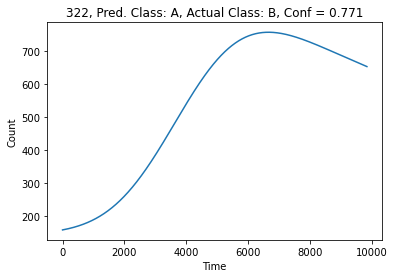

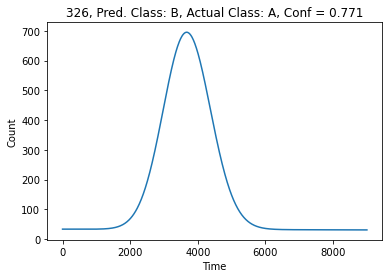

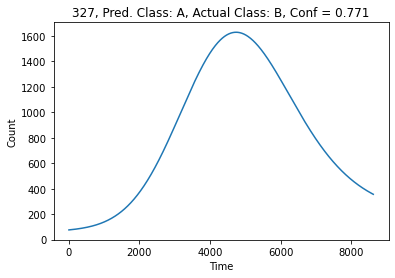

 33%|███▎      | 329/1000 [00:09<00:18, 36.41it/s]

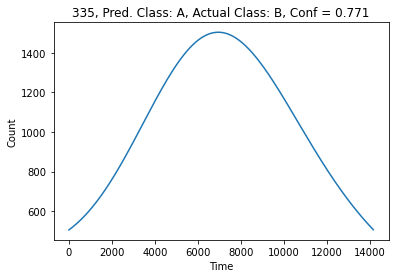

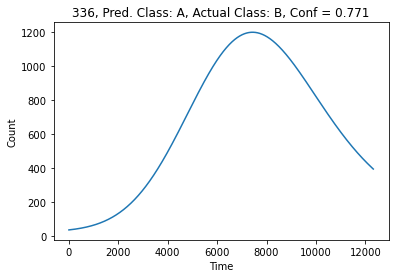

 34%|███▍      | 338/1000 [00:09<00:18, 35.70it/s]

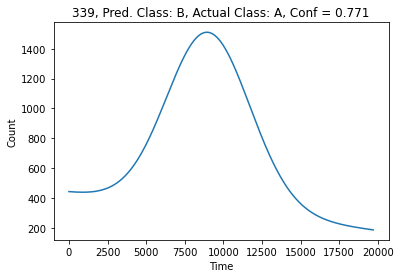

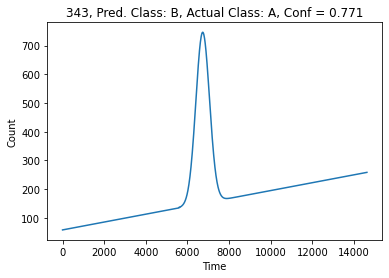

 34%|███▍      | 345/1000 [00:09<00:19, 33.55it/s]

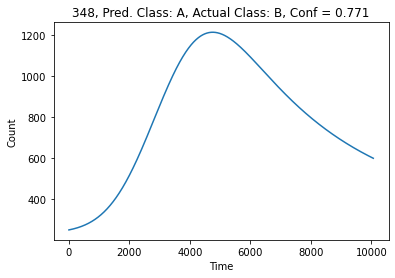

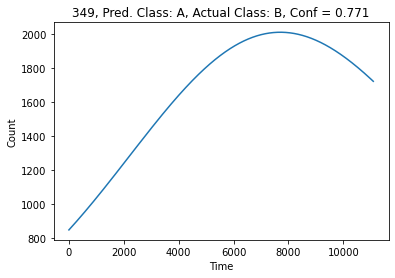

 35%|███▌      | 351/1000 [00:10<00:20, 31.67it/s]

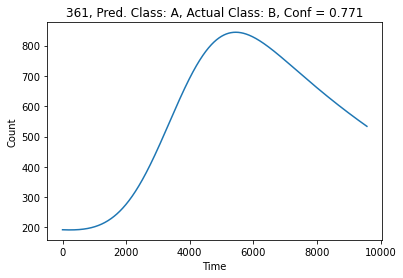

 36%|███▌      | 362/1000 [00:10<00:16, 39.66it/s]

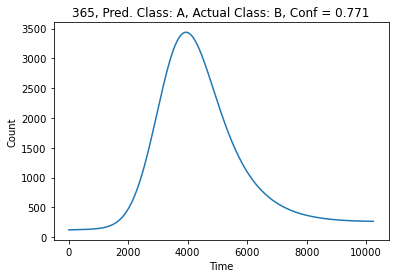

 37%|███▋      | 368/1000 [00:10<00:15, 40.63it/s]

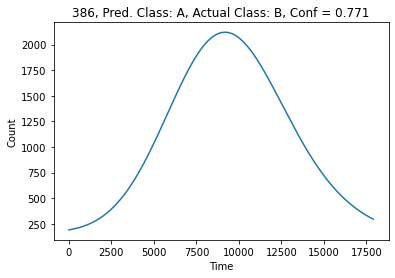

 39%|███▊      | 387/1000 [00:10<00:09, 62.40it/s]

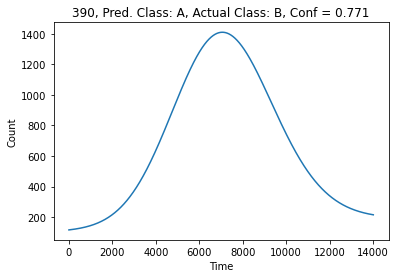

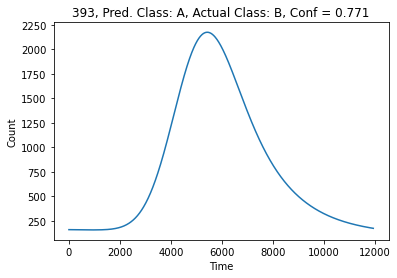

 40%|███▉      | 396/1000 [00:10<00:11, 54.68it/s]

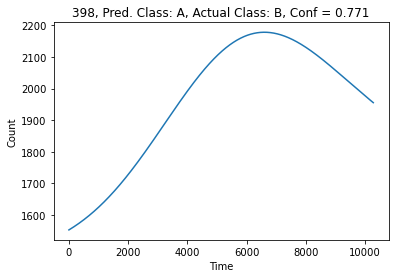

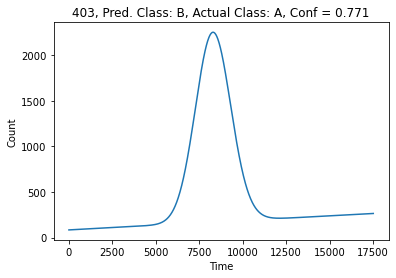

 40%|████      | 404/1000 [00:10<00:12, 48.49it/s]

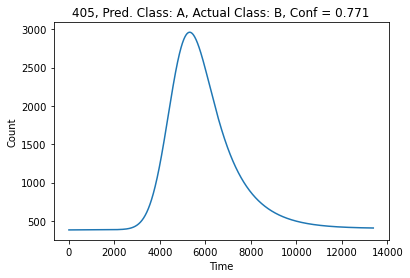

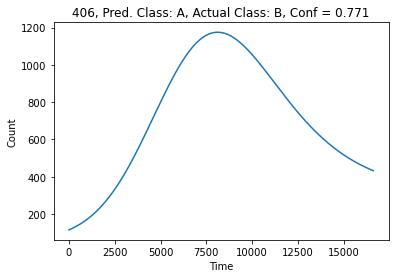

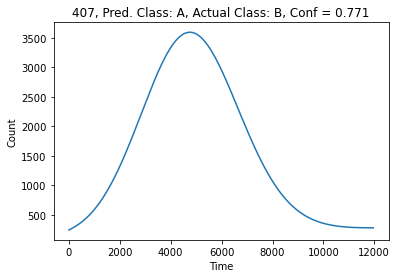

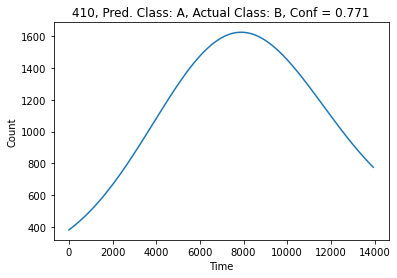

 41%|████      | 411/1000 [00:11<00:18, 32.62it/s]

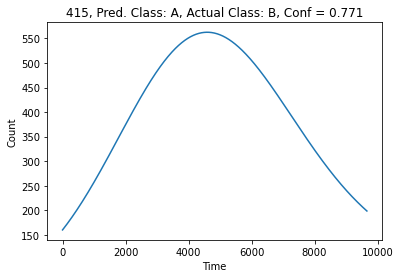

 42%|████▏     | 416/1000 [00:11<00:17, 33.98it/s]

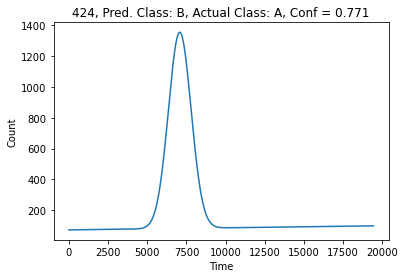

 42%|████▎     | 425/1000 [00:11<00:14, 40.58it/s]

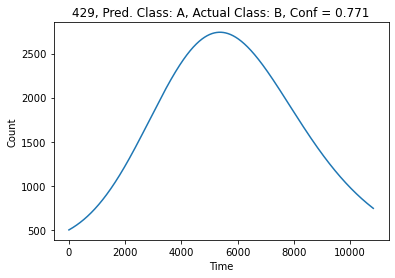

 43%|████▎     | 431/1000 [00:11<00:12, 43.87it/s]

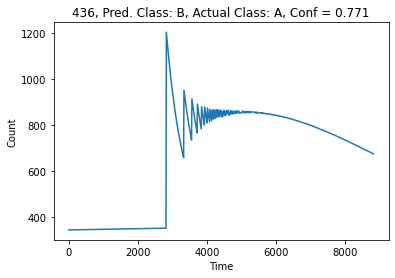

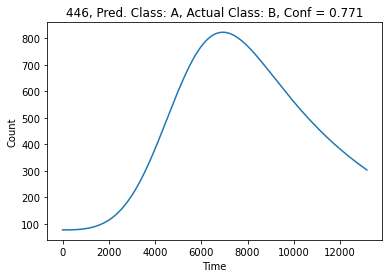

 45%|████▍     | 447/1000 [00:11<00:10, 54.50it/s]

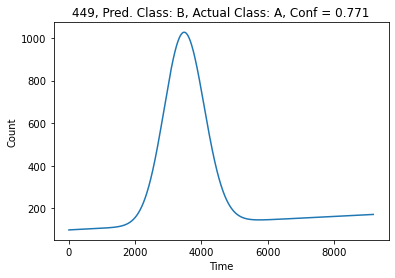

 45%|████▌     | 454/1000 [00:12<00:09, 56.96it/s]

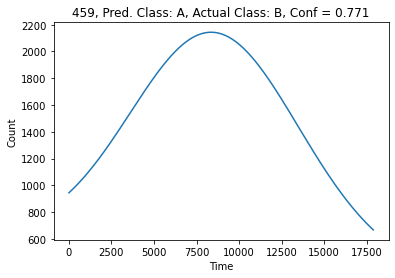

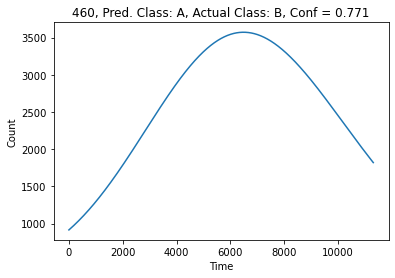

 46%|████▌     | 461/1000 [00:12<00:16, 33.53it/s]

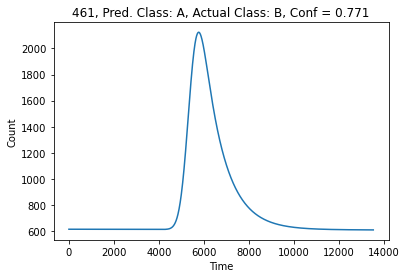

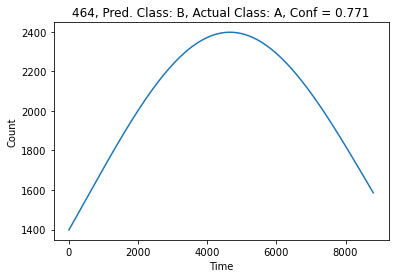

 47%|████▋     | 466/1000 [00:12<00:18, 28.83it/s]

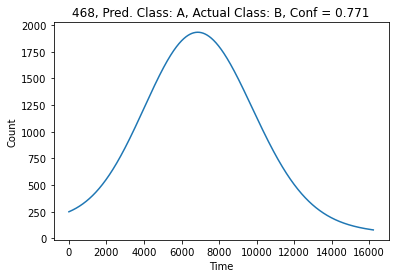

 47%|████▋     | 470/1000 [00:12<00:17, 29.50it/s]

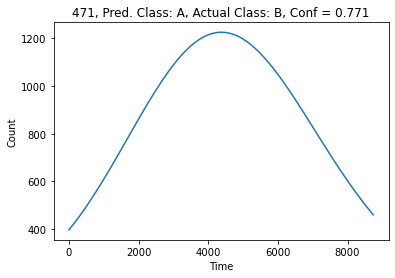

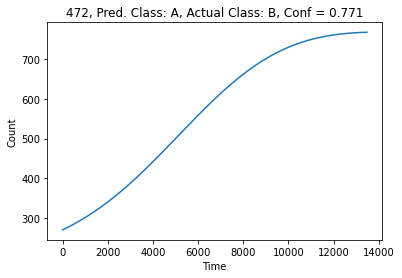

 47%|████▋     | 474/1000 [00:13<00:19, 26.52it/s]

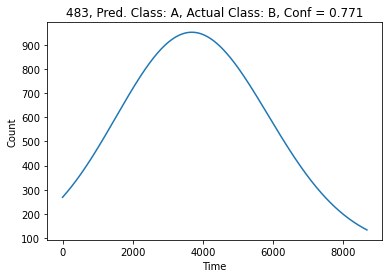

 48%|████▊     | 484/1000 [00:13<00:13, 37.28it/s]

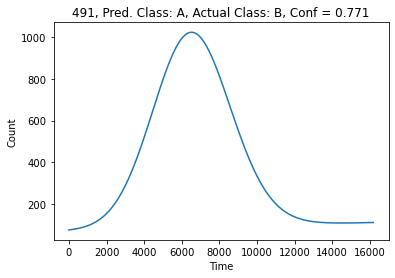

 49%|████▉     | 492/1000 [00:13<00:11, 43.98it/s]

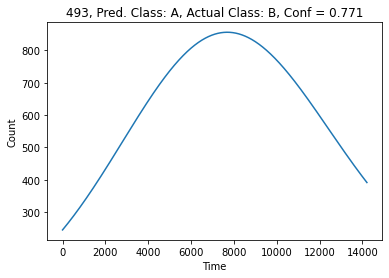

 50%|████▉     | 498/1000 [00:13<00:10, 45.72it/s]

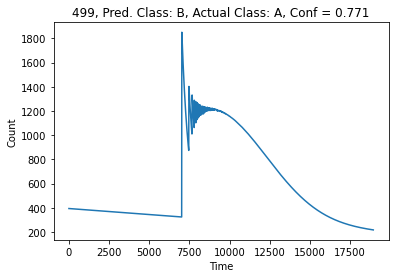

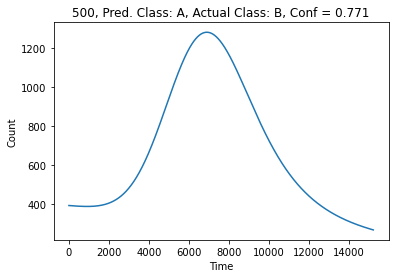

 50%|█████     | 504/1000 [00:13<00:13, 37.13it/s]

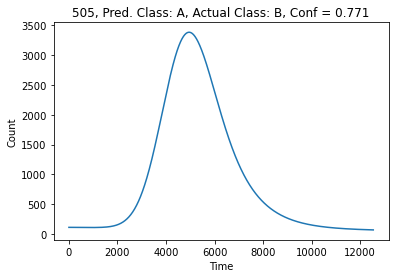

 51%|█████     | 509/1000 [00:13<00:12, 37.93it/s]

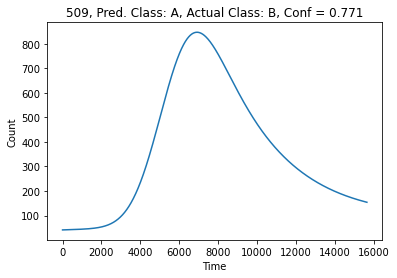

 51%|█████▏    | 514/1000 [00:13<00:12, 38.56it/s]

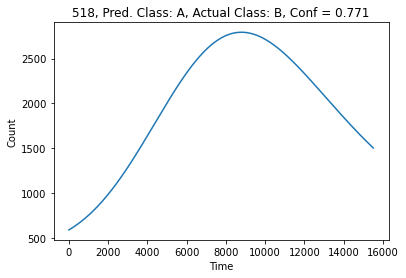

 52%|█████▏    | 519/1000 [00:14<00:12, 39.69it/s]

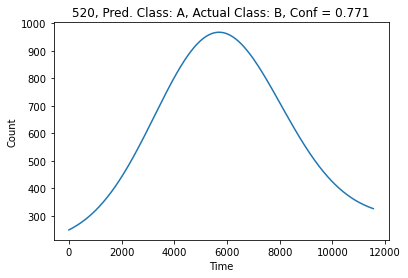

 52%|█████▏    | 524/1000 [00:14<00:11, 40.57it/s]

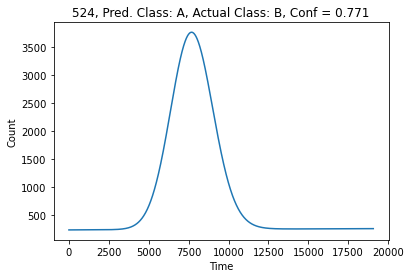

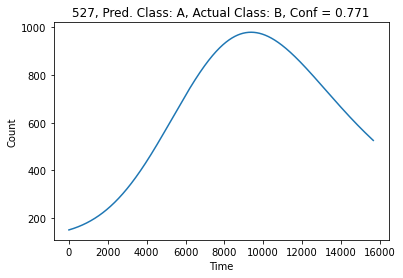

 53%|█████▎    | 529/1000 [00:14<00:15, 31.39it/s]

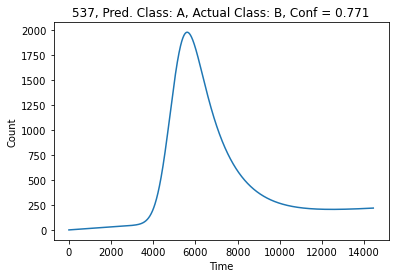

 54%|█████▍    | 538/1000 [00:14<00:11, 40.36it/s]

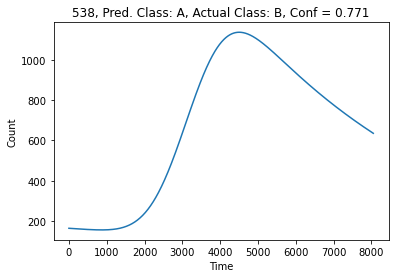

 54%|█████▍    | 543/1000 [00:14<00:12, 35.56it/s]

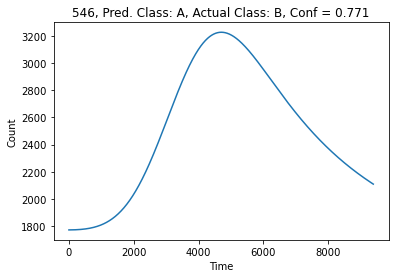

 55%|█████▍    | 547/1000 [00:14<00:12, 35.69it/s]

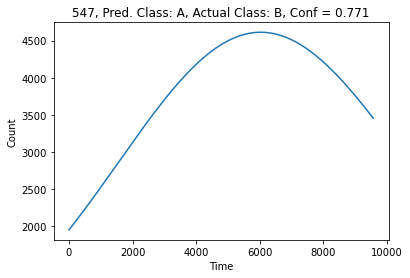

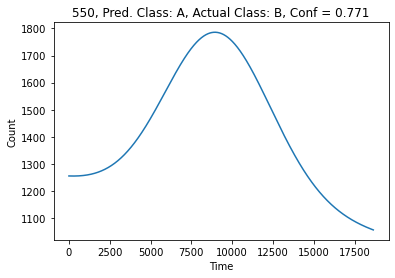

 55%|█████▌    | 551/1000 [00:15<00:15, 28.08it/s]

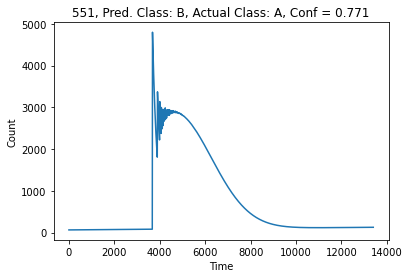

 56%|█████▌    | 555/1000 [00:15<00:15, 29.52it/s]

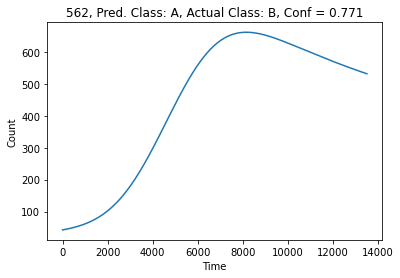

 56%|█████▋    | 563/1000 [00:15<00:11, 37.70it/s]

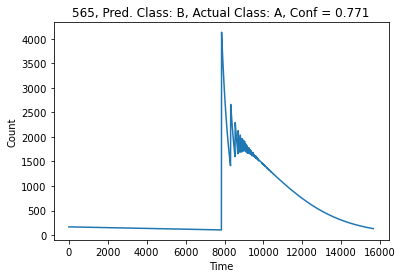

 57%|█████▋    | 568/1000 [00:15<00:11, 38.55it/s]

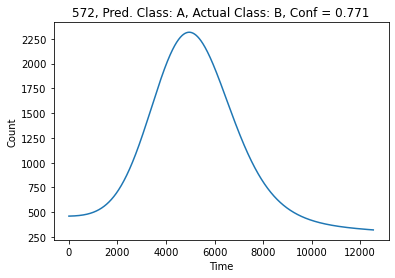

 57%|█████▋    | 573/1000 [00:15<00:10, 39.21it/s]

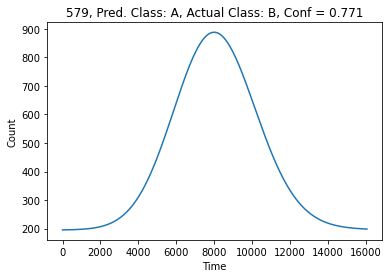

 58%|█████▊    | 580/1000 [00:15<00:09, 44.56it/s]

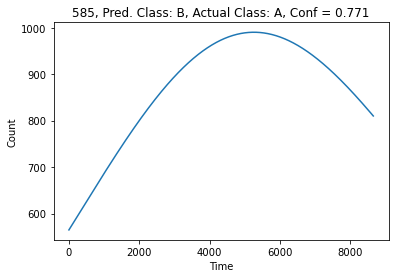

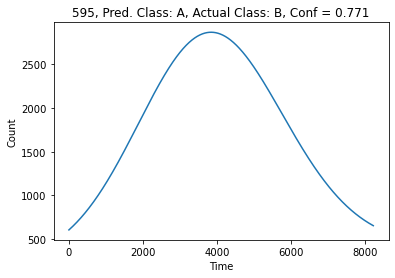

 60%|█████▉    | 596/1000 [00:15<00:06, 59.47it/s]

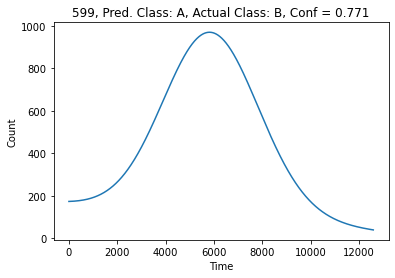

 60%|██████    | 602/1000 [00:16<00:06, 58.48it/s]

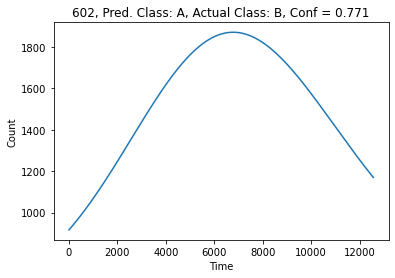

 61%|██████    | 608/1000 [00:16<00:11, 34.32it/s]

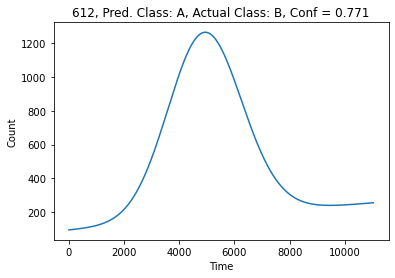

 61%|██████▏   | 613/1000 [00:16<00:10, 36.86it/s]

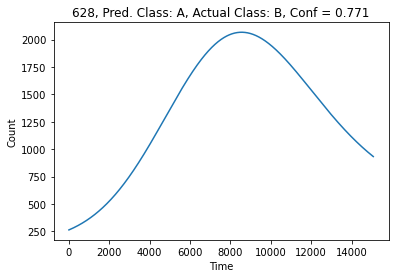

 63%|██████▎   | 629/1000 [00:16<00:06, 58.37it/s]

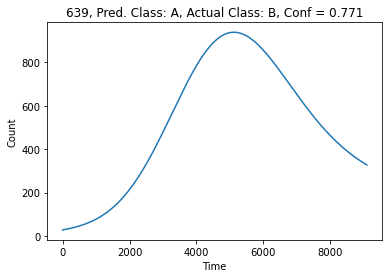

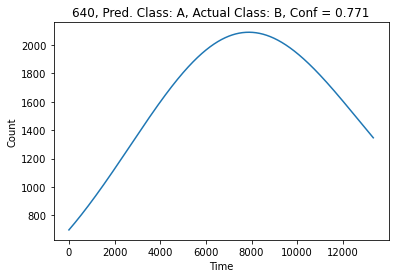

 64%|██████▍   | 641/1000 [00:16<00:06, 57.71it/s]

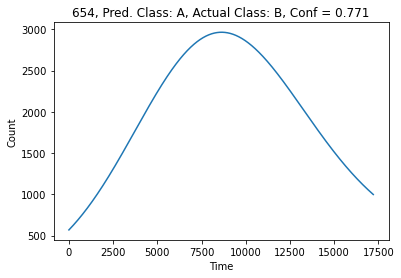

 66%|██████▌   | 655/1000 [00:16<00:04, 71.66it/s]

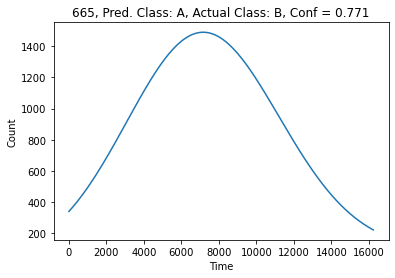

 67%|██████▋   | 666/1000 [00:17<00:04, 74.82it/s]

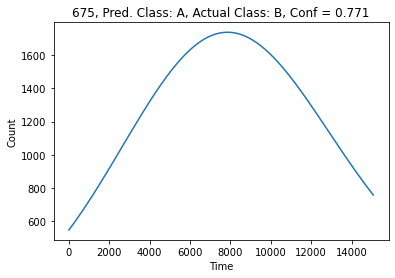

 68%|██████▊   | 676/1000 [00:17<00:04, 78.26it/s]

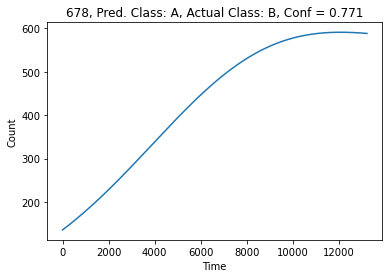

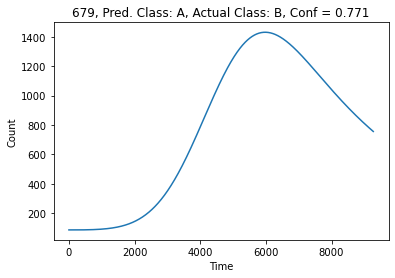

 68%|██████▊   | 685/1000 [00:17<00:05, 62.08it/s]

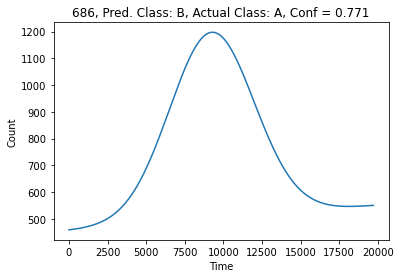

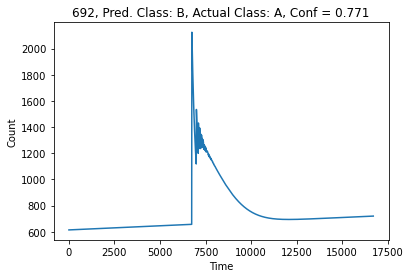

 69%|██████▉   | 693/1000 [00:17<00:06, 48.14it/s]

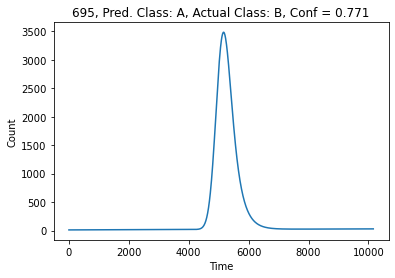

 70%|██████▉   | 699/1000 [00:17<00:06, 45.20it/s]

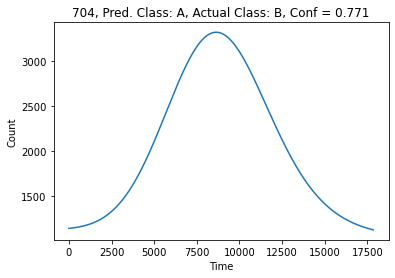

 70%|███████   | 705/1000 [00:18<00:06, 45.48it/s]

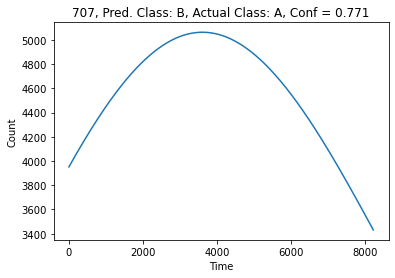

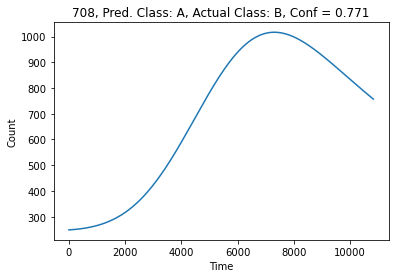

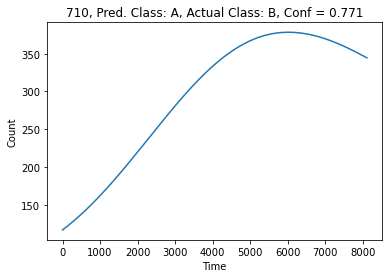

 71%|███████   | 711/1000 [00:18<00:09, 29.54it/s]

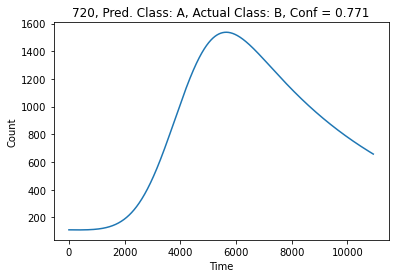

 72%|███████▏  | 721/1000 [00:18<00:07, 38.26it/s]

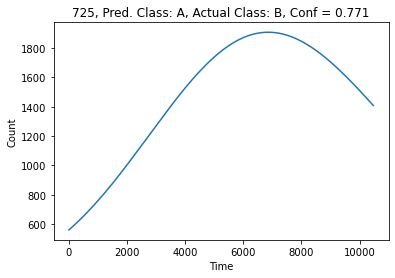

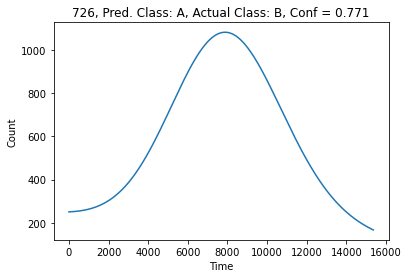

 73%|███████▎  | 727/1000 [00:18<00:08, 32.24it/s]

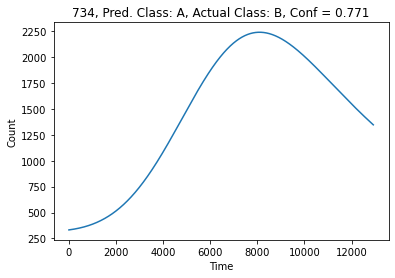

 74%|███████▎  | 735/1000 [00:19<00:07, 35.30it/s]

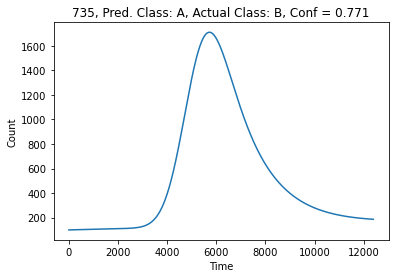

 74%|███████▍  | 740/1000 [00:19<00:07, 33.89it/s]

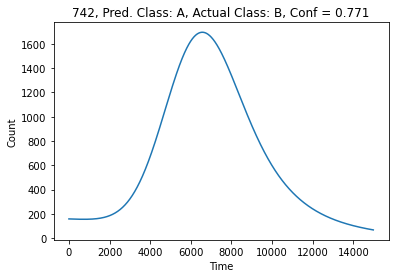

 74%|███████▍  | 744/1000 [00:19<00:07, 33.22it/s]

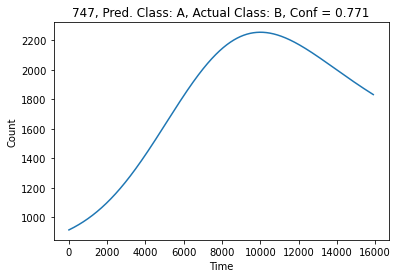

 75%|███████▍  | 748/1000 [00:19<00:07, 33.17it/s]

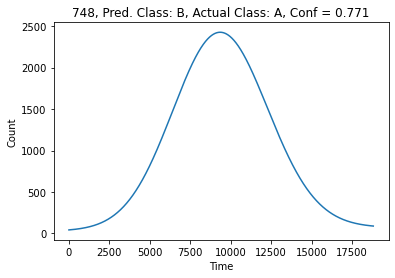

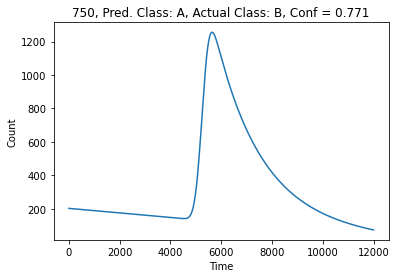

 75%|███████▌  | 752/1000 [00:19<00:09, 26.17it/s]

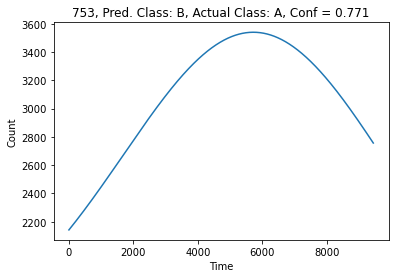

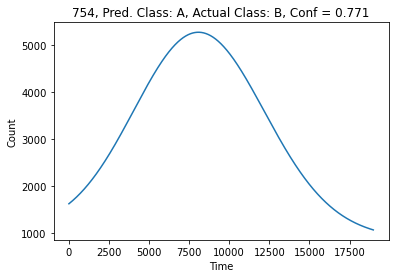

 76%|███████▌  | 755/1000 [00:19<00:11, 21.80it/s]

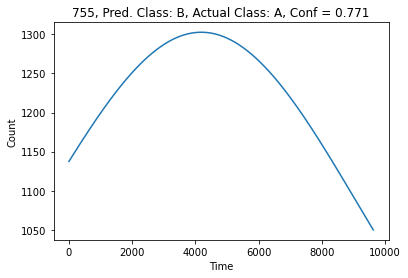

 76%|███████▌  | 758/1000 [00:20<00:10, 22.95it/s]

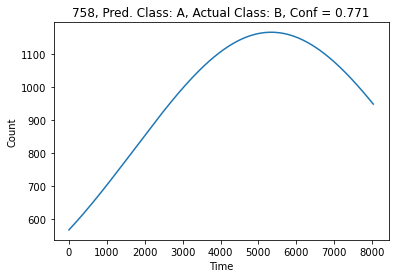

 76%|███████▌  | 761/1000 [00:20<00:10, 23.71it/s]

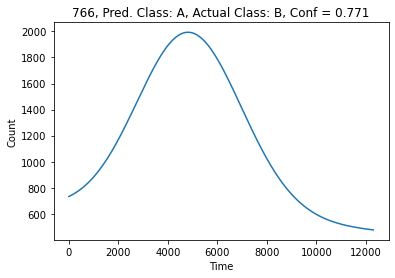

 77%|███████▋  | 767/1000 [00:20<00:07, 30.46it/s]

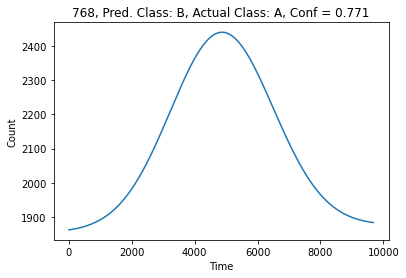

 77%|███████▋  | 771/1000 [00:20<00:11, 20.46it/s]

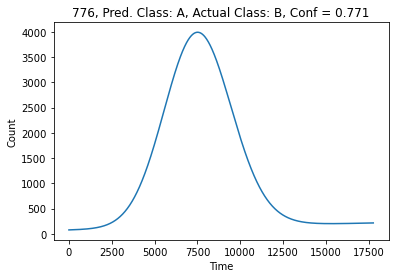

 78%|███████▊  | 777/1000 [00:20<00:08, 25.53it/s]

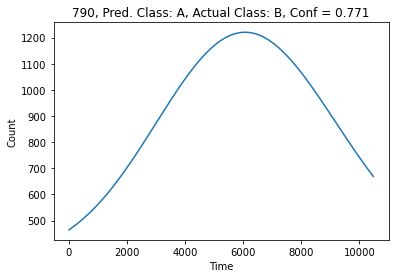

 79%|███████▉  | 791/1000 [00:20<00:04, 44.42it/s]

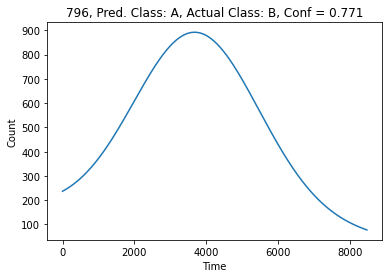

 80%|███████▉  | 797/1000 [00:21<00:04, 43.20it/s]

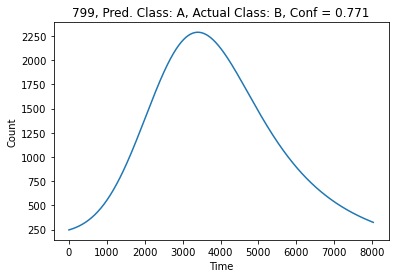

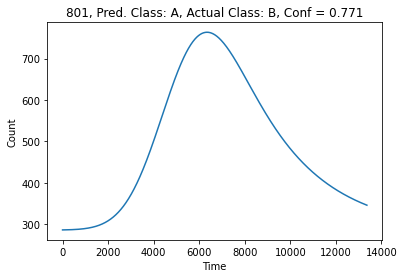

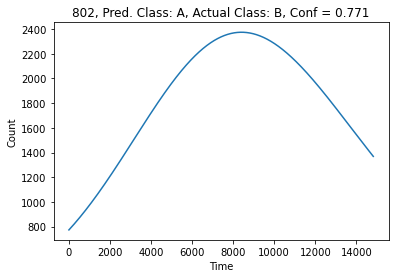

 80%|████████  | 803/1000 [00:21<00:06, 28.20it/s]

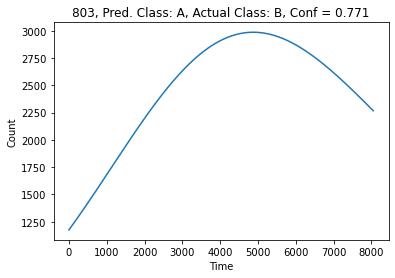

 81%|████████  | 807/1000 [00:21<00:06, 28.80it/s]

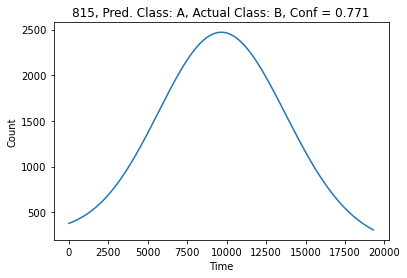

 82%|████████▏ | 816/1000 [00:21<00:04, 38.52it/s]

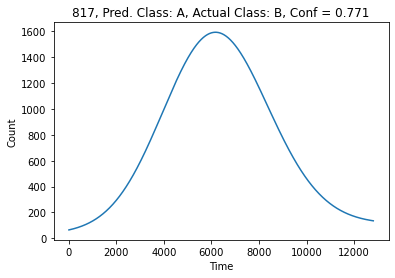

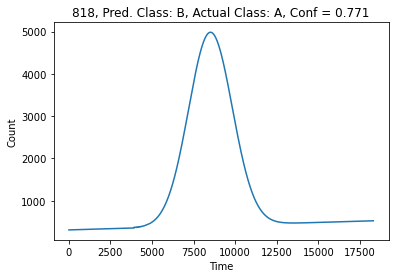

 82%|████████▏ | 821/1000 [00:21<00:05, 32.29it/s]

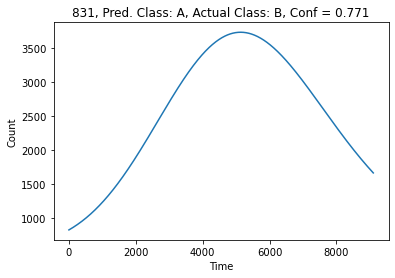

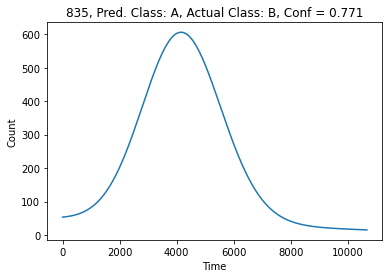

 84%|████████▎ | 836/1000 [00:22<00:03, 45.07it/s]

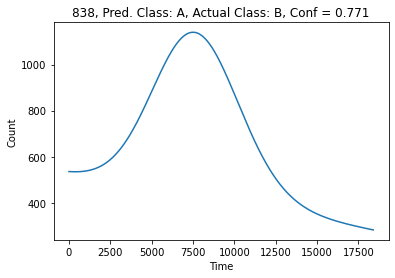

 84%|████████▍ | 842/1000 [00:22<00:03, 47.33it/s]

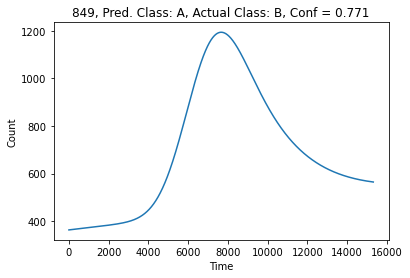

 85%|████████▌ | 850/1000 [00:22<00:02, 52.27it/s]

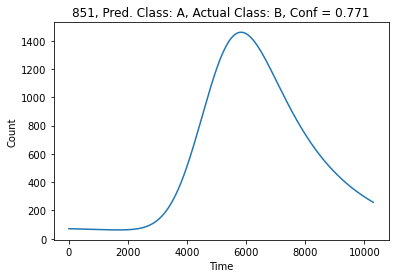

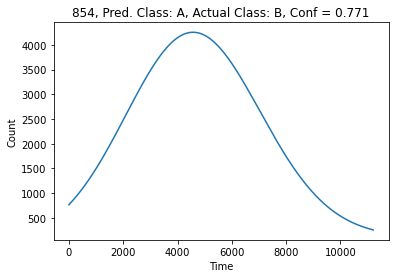

 86%|████████▌ | 856/1000 [00:22<00:03, 42.05it/s]

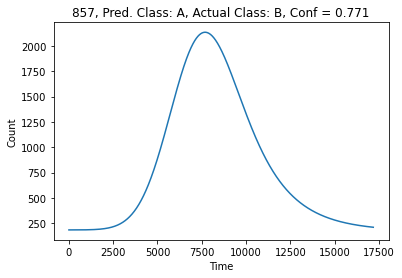

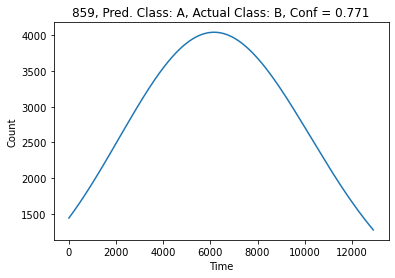

 86%|████████▌ | 861/1000 [00:22<00:04, 34.73it/s]

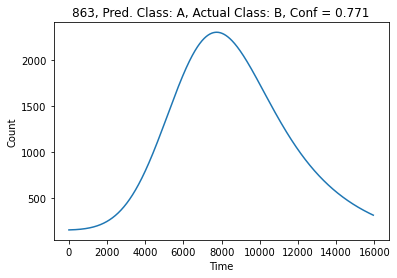

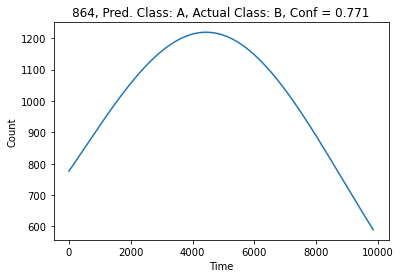

 87%|████████▋ | 866/1000 [00:23<00:04, 30.71it/s]

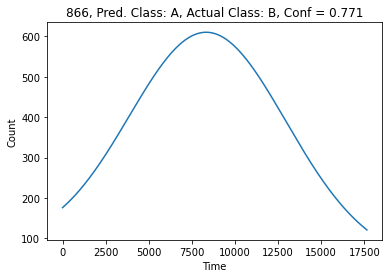

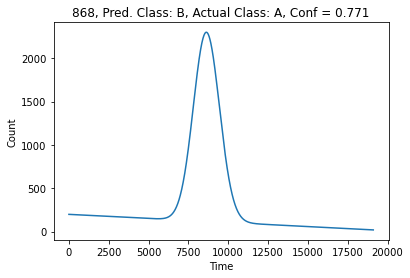

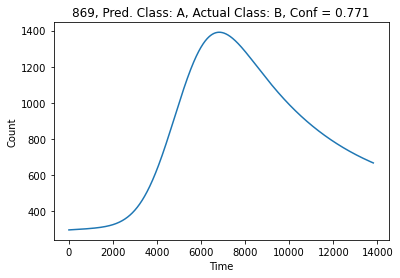

 87%|████████▋ | 870/1000 [00:23<00:05, 22.27it/s]

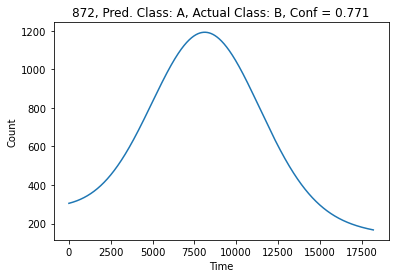

 87%|████████▋ | 873/1000 [00:23<00:05, 23.06it/s]

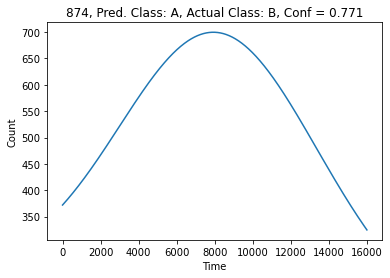

 88%|████████▊ | 876/1000 [00:23<00:05, 23.41it/s]

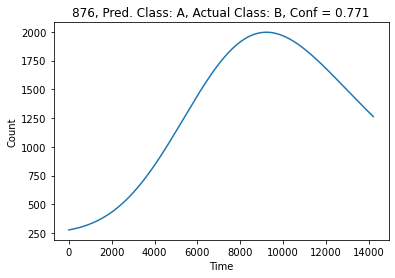

 88%|████████▊ | 879/1000 [00:23<00:05, 23.95it/s]

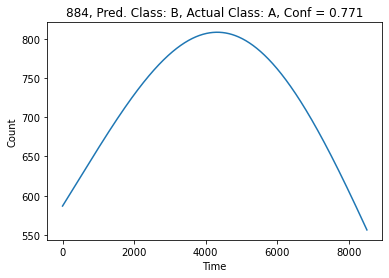

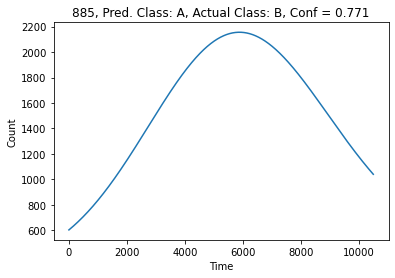

 89%|████████▊ | 886/1000 [00:23<00:04, 27.02it/s]

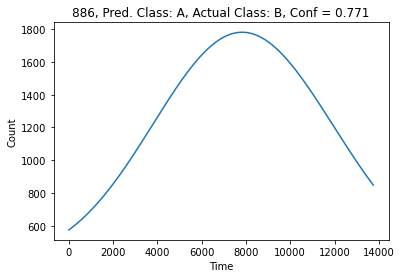

 89%|████████▉ | 889/1000 [00:24<00:04, 26.09it/s]

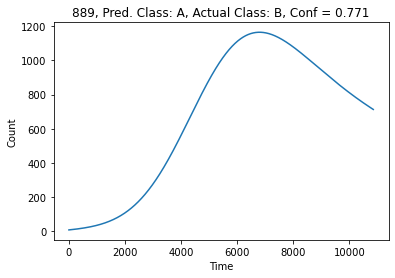

 89%|████████▉ | 892/1000 [00:24<00:06, 17.59it/s]

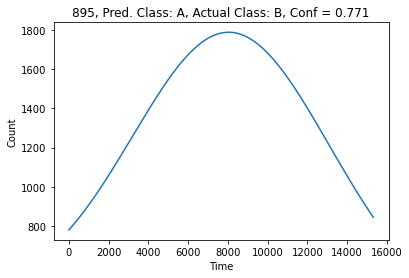

 90%|████████▉ | 896/1000 [00:24<00:05, 18.25it/s]

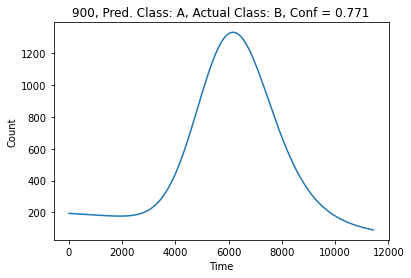

 90%|█████████ | 901/1000 [00:24<00:04, 23.12it/s]

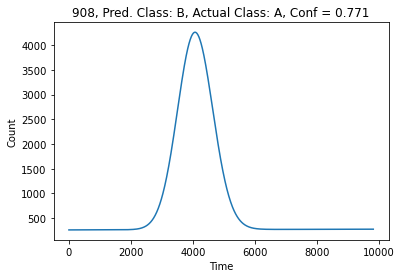

 91%|█████████ | 909/1000 [00:24<00:02, 32.83it/s]

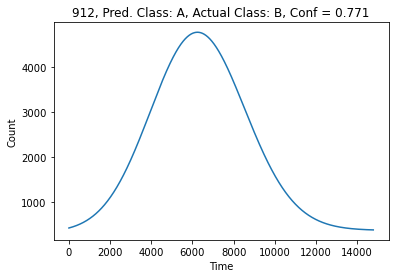

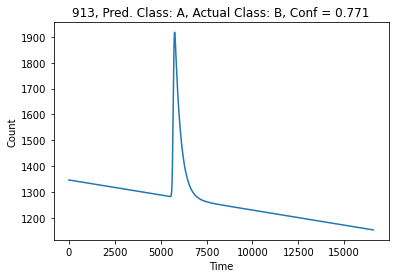

 91%|█████████▏| 914/1000 [00:25<00:03, 26.80it/s]

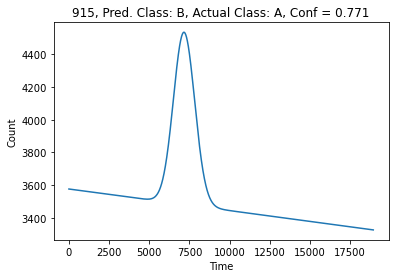

 92%|█████████▏| 918/1000 [00:25<00:02, 27.80it/s]

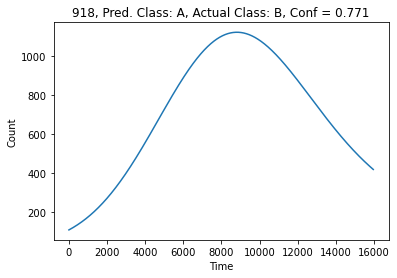

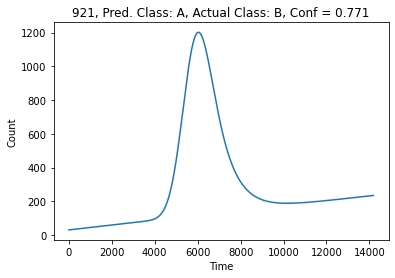

 92%|█████████▏| 922/1000 [00:25<00:03, 22.67it/s]

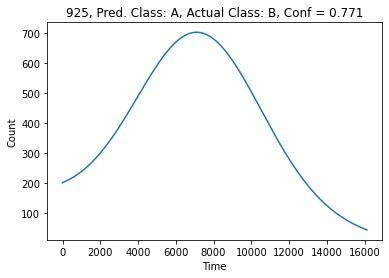

 93%|█████████▎| 926/1000 [00:25<00:03, 24.29it/s]

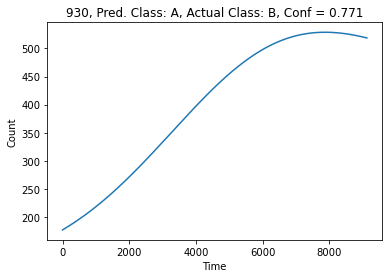

 93%|█████████▎| 931/1000 [00:25<00:02, 27.16it/s]

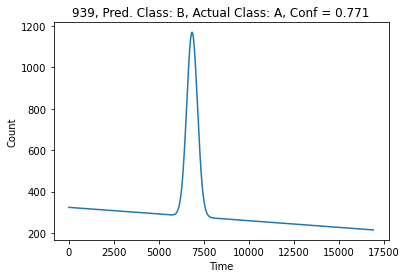

 94%|█████████▍| 940/1000 [00:26<00:01, 35.04it/s]

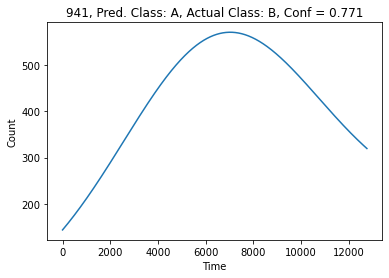

 94%|█████████▍| 944/1000 [00:26<00:01, 35.68it/s]

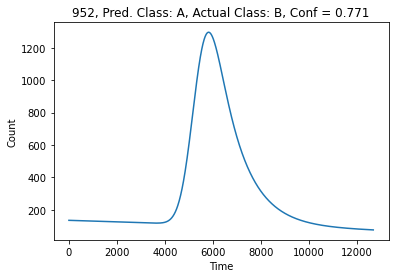

 95%|█████████▌| 953/1000 [00:26<00:01, 46.44it/s]

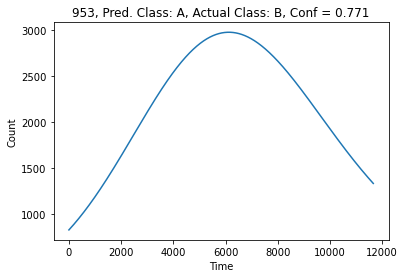

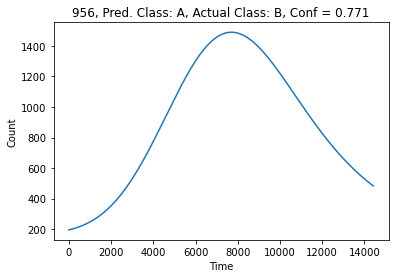

 96%|█████████▌| 959/1000 [00:26<00:01, 36.96it/s]

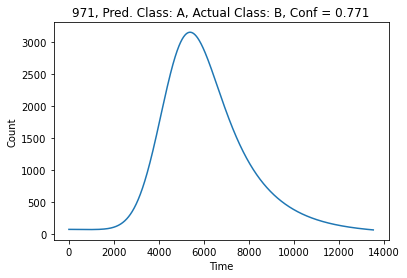

 97%|█████████▋| 972/1000 [00:26<00:00, 49.65it/s]

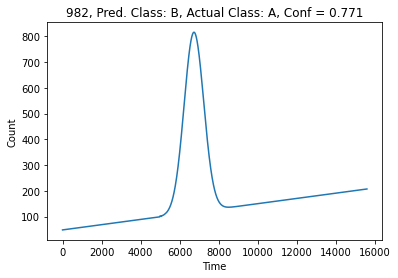

 98%|█████████▊| 983/1000 [00:26<00:00, 59.39it/s]

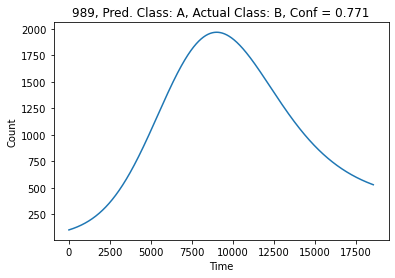

 99%|█████████▉| 990/1000 [00:26<00:00, 59.65it/s]

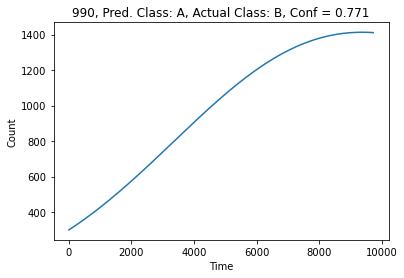

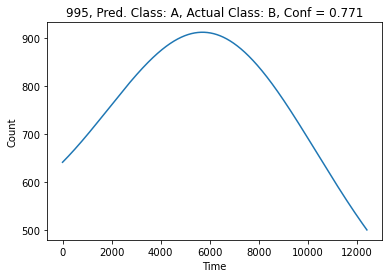

100%|██████████| 1000/1000 [00:27<00:00, 36.95it/s]


In [40]:
for i, pred3 in enumerate(tqdm(preds3)):
    pred3_class = int(np.round(pred3[0]))
    if class_list[str(pred3_class)] != class_list[str(labels[i])]:
        plt.plot(np.arange(0, len(data[i][data[i] != 0]))*10, data[i][data[i] != 0])

        plt.xlabel('Time')
        plt.ylabel('Count')

        plt.title(f"{ids[i]}, Pred. Class: {class_list[str(pred3_class)]}, Actual Class: {class_list[str(labels[i])]}, Conf = {np.round(conf, 3)}")
        plt.show()

# try k-fold validation for the final NN 
help me mein gottens

In [59]:
def get_merged_NN(data_train, data_val, 
                  data_deriv_train, data_deriv_val,
                  labels_train, labels_val):
    
    model1 = Sequential()   
    # First convolutional layer
    model1.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(len(data[0]), 1)))
    model1.add(MaxPooling1D(pool_size=2))
    # Second convolutional layer
    model1.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model1.add(MaxPooling1D(pool_size=2))
    # Third convolutional layer
    model1.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    model1.add(MaxPooling1D(pool_size=2))
    # Flatten the output
    model1.add(Flatten())
    # Fully connected layer
    model1.add(Dense(128, activation='relu'))
    model1.add(Dropout(0.5))
    # Output layer
    model1.add(Dense(1, activation='sigmoid'))
    # Compile the model
    model1.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    model1.fit(np.array(data_train), np.array(labels_train), epochs=100, batch_size=32, validation_split=0.2, verbose=0)
    
    model2 = Sequential()   
    # First convolutional layer
    model2.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(len(data[0]), 1)))
    model2.add(MaxPooling1D(pool_size=2))
    # Second convolutional layer
    model2.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model2.add(MaxPooling1D(pool_size=2))
    # Third convolutional layer
    model2.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    model2.add(MaxPooling1D(pool_size=2))
    # Flatten the output
    model2.add(Flatten())
    # Fully connected layer
    model2.add(Dense(128, activation='relu'))
    model2.add(Dropout(0.5))
    # Output layer
    model2.add(Dense(1, activation='sigmoid'))
    # Compile the model
    
    
    # THIS IS WHERE THE PROBLEM LIES 
    model2.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    model2.fit(np.array(data_deriv_train), np.array(labels_train), epochs=100, batch_size=32, validation_split=0.2, verbose=0)
    
    
    
    # final NN 
    merged = Concatenate()([model1.output, model2.output])

    # Add more layers 
    x = Dense(64, activation='relu')(merged)
    final_output = Dense(1, activation='sigmoid')(x)
    
    combined_model = Model(inputs=[model1.input, model2.input], outputs=final_output)
    combined_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    combined_model.fit([data_train, data_deriv_train], np.array(labels_train), epochs=100, batch_size=32)
    
    data_val_expanded = np.expand_dims(data_val, axis=-1)
    data_deriv_val_expanded = np.expand_dims(data_deriv_val, axis=-1)
    
    preds = model.predict([data_val_expanded, data_deriv_val_expanded])
    
    return preds


# HELP pls 
when compiling the model, i am encountering some sizing errors for the input shape of model2. I would very greatly appreciate some help with that :'). im not sure why it didnt come up when training individually. 

In [58]:
from sklearn.model_selection import KFold
from keras.layers import LSTM, Dense, Dropout, Bidirectional
import json
import gc

n_trials = 20

check = {}

acc = []
high_conf_acc = []
low_conf_acc = [] 

for n in range(n_trials):
    print(f'ITERATION {n+1}')

    kf = KFold(n_splits=2, shuffle=True)#, random_state=42) # shuffle folds each time
    
    for train_ind, val_ind in kf.split(data):
        data_train, data_val = data[train_ind], data[val_ind]
        data_deriv_train, data_deriv_val = data_deriv[train_ind], data_deriv[val_ind]
        labels_train, labels_val = np.array(labels)[train_ind], np.array(labels)[val_ind]
        ids_train, ids_val = np.array(ids)[train_ind], np.array(ids)[val_ind]
        
        preds = get_merged_NN(data_train, data_val, data_deriv_train, data_deriv_val, labels_train, labels_val)
        
        print(preds)
        
#         class_list = {'0': 'A', '1': 'B'}
        
#         num_high = 0
#         num_mis_high = 0
#         num_mis_low = 0
        
#         tot_exc = 0
        
#         for i, pred in enumerate(tqdm(preds)):
#             conf = np.abs(pred[0]-0.5)/0.5
#             pred_class = int(np.round(pred[0]))

#             tot_exc += 1
            
#             if conf > 0.9: # split by confidence levels, more easily identify initially incorrect classifications
#                 num_high += 1
        
#                 if class_list[str(pred_class)] != class_list[str(labels_val[i])]:
#                     if ids_val[i] not in check.keys():
#                         check[ids_val[i]] = {'high_conf_mis': 0, 'low_conf_mis': 0, 'low_conf_cor': 0}
                    
#                     check[ids_val[i]]['high_conf_mis'] += 1
                    
#                     num_mis_high += 1
    
#             else:
        
#                 if class_list[str(pred_class)] != class_list[str(labels_val[i])]:
#                     if ids_val[i] not in check.keys():
#                         check[ids_val[i]] = {'high_conf_mis': 0, 'low_conf_mis': 0, 'low_conf_cor': 0}
                    
#                     check[ids_val[i]]['low_conf_mis'] += 1
                    
#                     num_mis_low += 1
    

#                 else:
#                     if ids_val[i] not in check.keys():
#                         check[ids_val[i]] = {'high_conf_mis': 0, 'low_conf_mis': 0, 'low_conf_cor': 0}
                    
#                     check[ids_val[i]]['low_conf_cor'] += 1
    /
#         print(f'Number of high confidence classifications = {num_high}')
#         print(f'Number of low confidence classifications = {tot_exc - num_high}')
#         print(f'Percentage of high confidence = {num_high/tot_exc}')
        
#         print(f'Total misclassified = {num_mis_high + num_mis_low}')
#         print(f'Accuracy in total = {1-(num_mis_high + num_mis_low)/tot_exc}')
        
#         print(f'Accuracy of high confidence = {1-num_mis_high/num_high}')
    
#         acc.append(1-(num_mis_high + num_mis_low)/tot_exc)
#         high_conf_acc.append(1-num_mis_high/num_high)

#         try:
#             print(f'Accuracy of low confidence = {1-num_mis_low/(tot_exc - num_high)}')
#             low_conf_acc.append(1-num_mis_low/(tot_exc - num_high))
#         except ZeroDivisionError:
#             low_conf_acc.append(None)

# #with open('problem_ids.json', 'w') as f:
# #    json.dump(check, f)
        

ITERATION 1


ValueError: in user code:

    File "/opt/conda/lib/python3.9/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/opt/conda/lib/python3.9/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.9/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/opt/conda/lib/python3.9/site-packages/keras/src/engine/training.py", line 1080, in train_step
        y_pred = self(x, training=True)
    File "/opt/conda/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/conda/lib/python3.9/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_8" is incompatible with the layer: expected shape=(None, 1999, 1), found shape=(None, 1998)
